# Natural Language Processing -- Sentiment Analysis #

## CAUTION!!! You may find the content *offensive*!

# Problem Statement

Social networks and media platforms are challenged with effectively facilitating open conversations. This results in many such communities preventing users from expressing their opinions, giving feedback etc. on their platform. On the other hand, in open forums the possibility of being verbally abused and harassed by strangers online is not a great motivator for people to engage and learn from one another's perspectives.

# Goal

Develop a set of NLP models that can classify texts that are ***toxic, severe-toxic, threatening, insulting, hateful and/or obscene*** in nature.

# Metrics

Model Evaluation
* High Sensitivity; Low False Negatives 



## Import neccessary data processing and visualization libraries

In [1]:
# Data processing and modeling
import re
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from scipy.sparse import hstack

from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

# conda install -c conda-forge spacy
# python -m spacy download en
from spacy import load
nlp = load('en') # load model with shortcut link "en"

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud
plt.style.use("ggplot")
sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16

# Change pandas default options
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', 800)

### Load and Examine data

##### *NOTE*: For the sake of faster execution times, limit the number of rows retrieved

In [3]:
# rows_limit=1000
# data = pd.read_csv("train.csv",nrows=rows_limit)

# NOTE: Uncomment the following when not in "test" mode; This will take some code snippets to take longer than you'd want to wait!
data = pd.read_csv("../data/train.csv")

In [4]:
data.shape

(159571, 8)

In [4]:
data.sample(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
113038,5c83bb581a1f5b8a,"(UTC)\n\nDropping the External links and the Further reading as unncessary—should be used in direct verification; currently: Bibliography and Notes subsection accomplish this, and it also brings the reader closer to the source. 09:28, 15 February 2009",0,0,0,0,0,0
49758,85095b9c2a8aaf31,".\n\nAgain, you have been exposed",0,0,0,0,0,0
145708,20f92ea8e1690ba8,"""\n\n Urgent sabotage of page! \n\nSignificant parts of this page were deleted. These deletions could result in deaths of innocent lives. The truth needs to be shared.\n\nQuran (8:12) - """"I will cast terror into the hearts of those who disbelieve. Therefore strike off their heads and strike off every fingertip of them""""\n\nDo not censor Wikipedia. Do not silence the truth. Do not be in denial!""",0,0,0,0,0,0
39129,6869c0eec832fcdd,REDIRECT Talk:List of Saturn-crossing minor planet,0,0,0,0,0,0
143823,032e9cb30614e4da,REDIRECT Talk:Age of Conan: Unchained,0,0,0,0,0,0
106688,3a9d1d3c68ec37b8,"Shut up and mind you own business to idiot, your going to be blocked for breaking the 3RR on the Brett Favre page along with PSUMark2006, you were not fixing vandalism, so that requires a suspension and you better quit bothering me, starwars1955",1,0,1,0,1,0
117280,72ad0681e01b393a,"""\n\n Symbolism of resignation date \n\nIt should be noted that Joseph Ratzinger, ex-conscript in (Adolf) Hitler Youth, announced its resignation as Pope Benedict XVI on february 11th 2013, Benedict of Aniane and Adolf of Osnabrück feast dayCaholic online. February fest days http://www.catholic.org/saints/f_day/feb.php. Maybe, this shoud be added in hid biography. \nWP:SYNTH \nClose, but there's no conclusion. Not combining sources, just listing two. Just out of curiousity, NummerSechs, why should this be noted? Is there anything beyond it just being a sort of weird coincidence? (talk) 02:22, April 4, 2013 (UTC)\nPlease READ WP:SYNTH which says: Do not combine material from multiple sources to reach or imply a conclusion not explicitly stated by any of the sources. If one reliable...",0,0,0,0,0,0
41532,6ec1c5bba4d0e3f6,i am sorry but please get me more friends on roblox the only i have edited this time is because i dont know how to contact you,0,0,0,0,0,0
8558,16b8c15eda866ba4,"Calling idiots stupid and retarded doesn't qualify as a personal attack because it's true, and the only way you wouldn't know this is because you're stupid and retarded.",1,0,1,0,1,0
52947,8d814796bd352cb7,"no reason not to include a mention in the same manner as the film mentioned at the end of the articleor remove the mention to the film, I suppose. (smallwhitelight)",0,0,0,0,0,0


##### **Observations**: 
* Note that a given comment may be classified as one or more classes -- ***toxic, severe_toxic, obscene, threat, insult and/or identity_hate***
* Will need to create six (6) models -- one per target/class

## Exploratory Data Analysis

#### Check to see if there are any missing values

In [5]:
data.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

#### Examine baseline distribution across all targets

In [6]:
targets = ['toxic', 'insult', 'obscene', 'identity_hate', 'severe_toxic', 'threat']

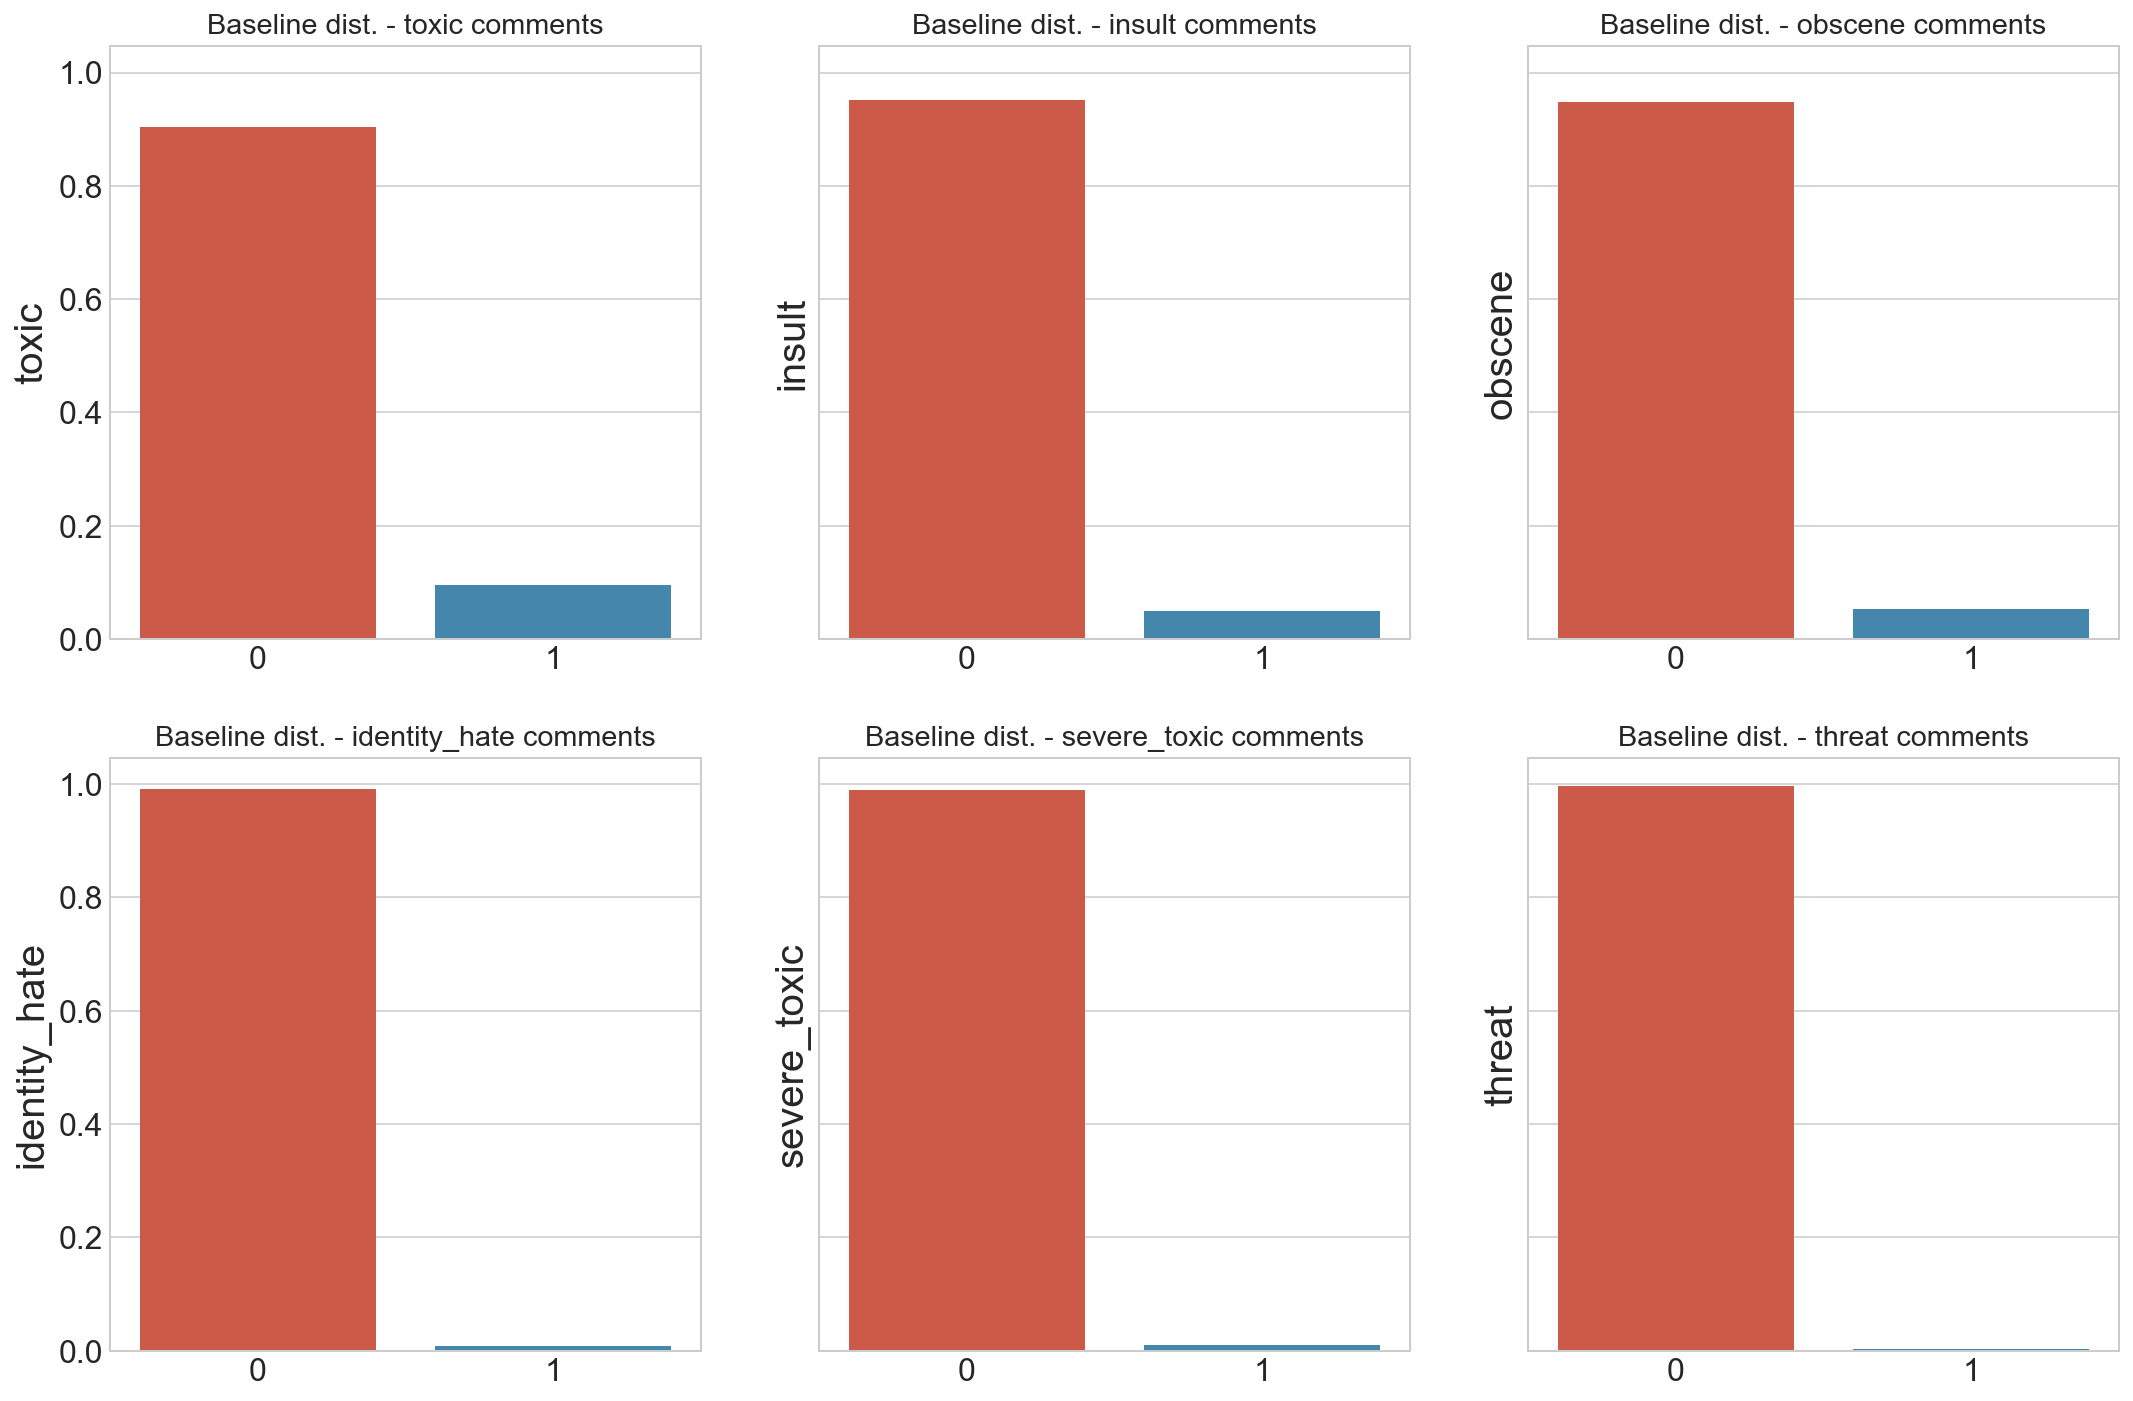

In [7]:
f, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = sns.mpl.pyplot.subplots(2, 3, figsize=(18,12), sharey="all")
axes = [ax1,ax2,ax3,ax4,ax5,ax6]

for i,target in enumerate(targets):
    ax = axes[i]
    ax.set_title("Baseline dist. - "+target+" comments")
    sns.barplot(x=data[target].value_counts().index, y=data[target].value_counts(normalize=True), ax=ax);

##### **Observation**: All classes are heavily imbalanced so techniques such as ***oversampling-undersampling, bias correction, stratified cross-validation, and changing thresholdfor classification*** would be beneficial during ML model creation and evaluation process.

#### Visualize comments length distribution

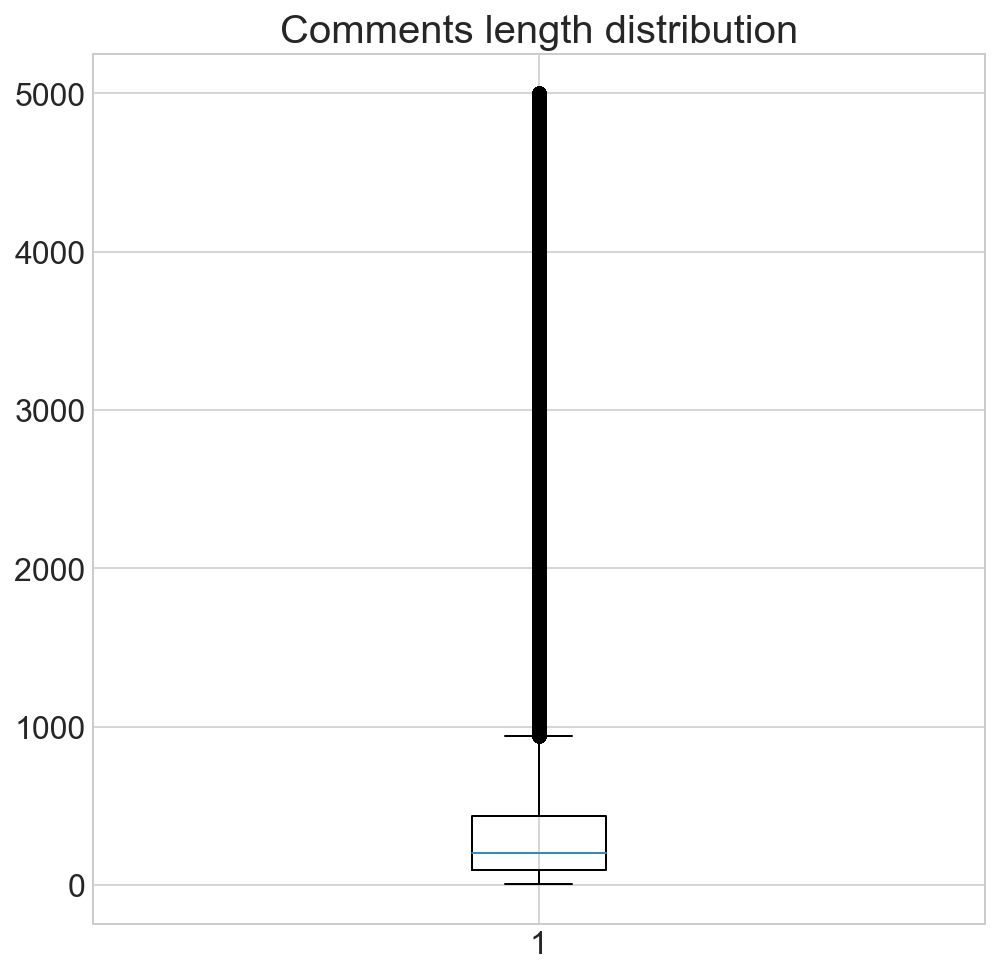

In [8]:
comments_lengths = [len(comment.strip()) for comment in data["comment_text"]]
sns.mpl.pyplot.figure(figsize=(8, 8))
sns.mpl.pyplot.title("Comments length distribution", fontsize=20)
sns.mpl.pyplot.boxplot(comments_lengths)
plt.show();

In [9]:
print("Avg length: {0:.2f}".format(np.mean(comments_lengths)))

Avg length: 394.07


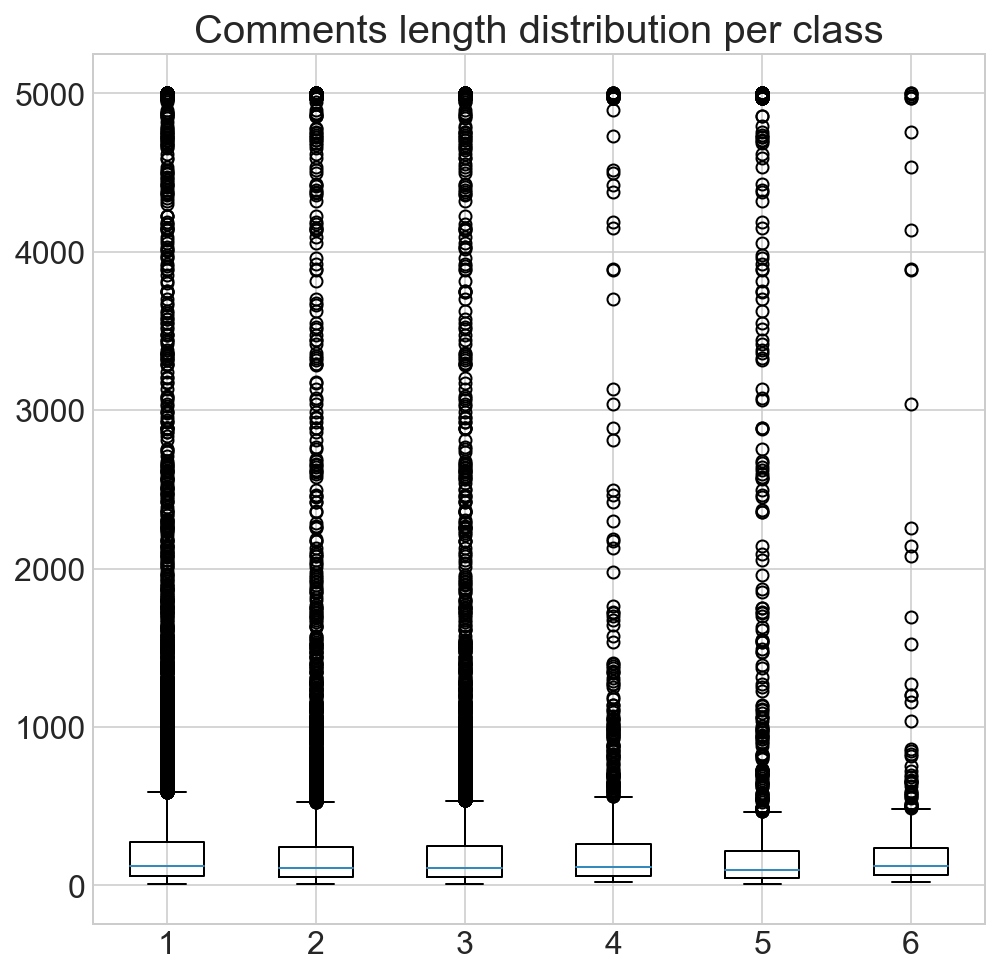

In [10]:
sns.mpl.pyplot.figure(figsize=(8, 8))
sns.mpl.pyplot.title("Comments length distribution per class", fontsize=20)
per_class_comments_lenghts = {}
for target in targets:
    target_comments_lengths = [len(comment.strip()) for comment in data.loc[data[target]==1]["comment_text"]]
    per_class_comments_lenghts[target] = target_comments_lengths
sns.mpl.pyplot.boxplot(x=per_class_comments_lenghts.values())
plt.show();

In [11]:
for k,v in per_class_comments_lenghts.items():
    print("Avg length per {1} comment  : {0:.2f}".format(np.mean(per_class_comments_lenghts[k]),k))

Avg length per toxic comment  : 295.25
Avg length per insult comment  : 277.28
Avg length per obscene comment  : 286.78
Avg length per identity_hate comment  : 308.54
Avg length per severe_toxic comment  : 453.64
Avg length per threat comment  : 307.74


#### Examine correlations between classes

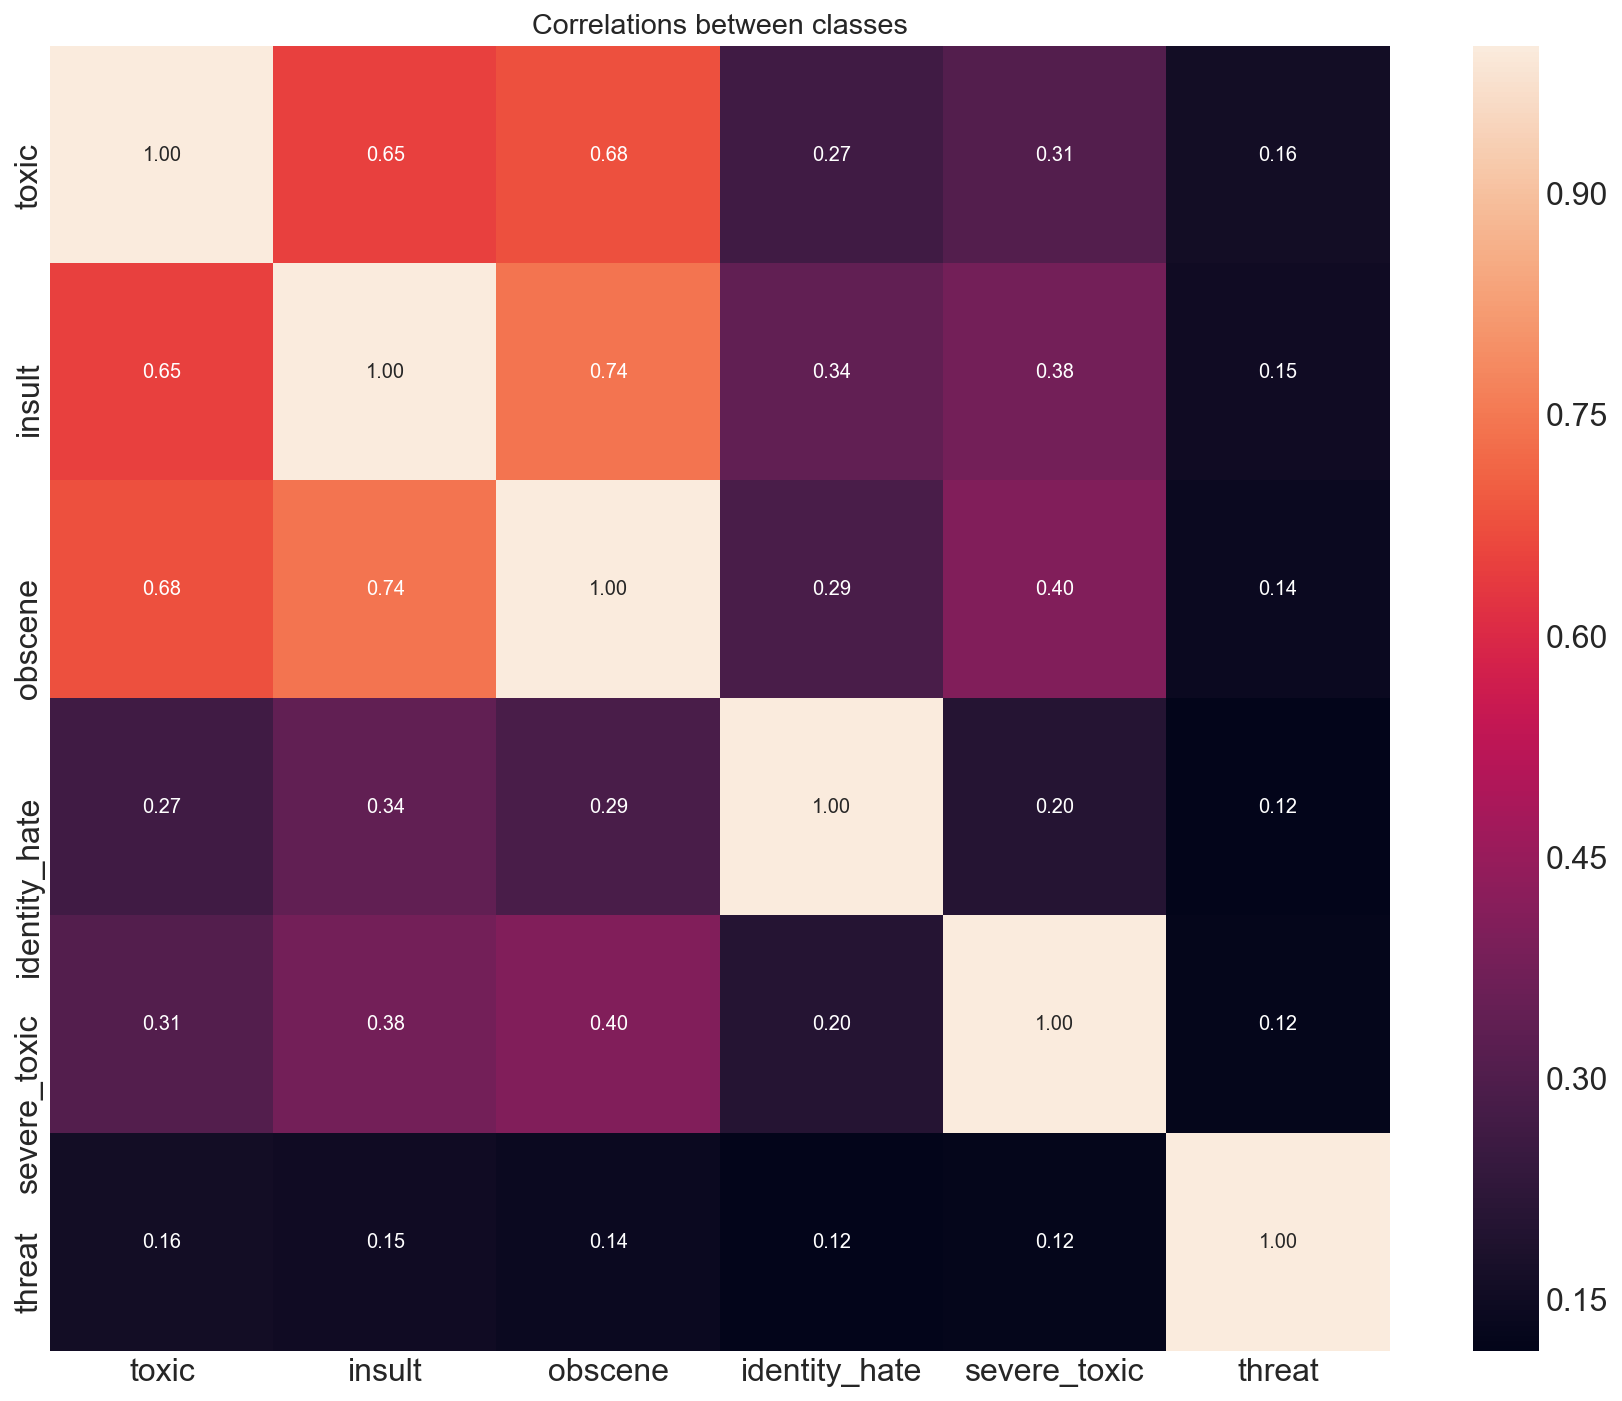

In [12]:
features = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
sns.mpl.pyplot.figure(figsize=(15, 12))
sns.mpl.pyplot.title("Correlations between classes")
sns.heatmap(data[targets].corr(), annot=True, fmt=".2f");

##### **Observation**: Interestingly there's high correlation between obscene & toxic and obscene & insulting _but_ not between toxic and server_toxic. The reason behind creating this correlation matrix is to see if a given class can be leveraged as a feature when creating models for one of the other classes.

#### Number of comments per class  

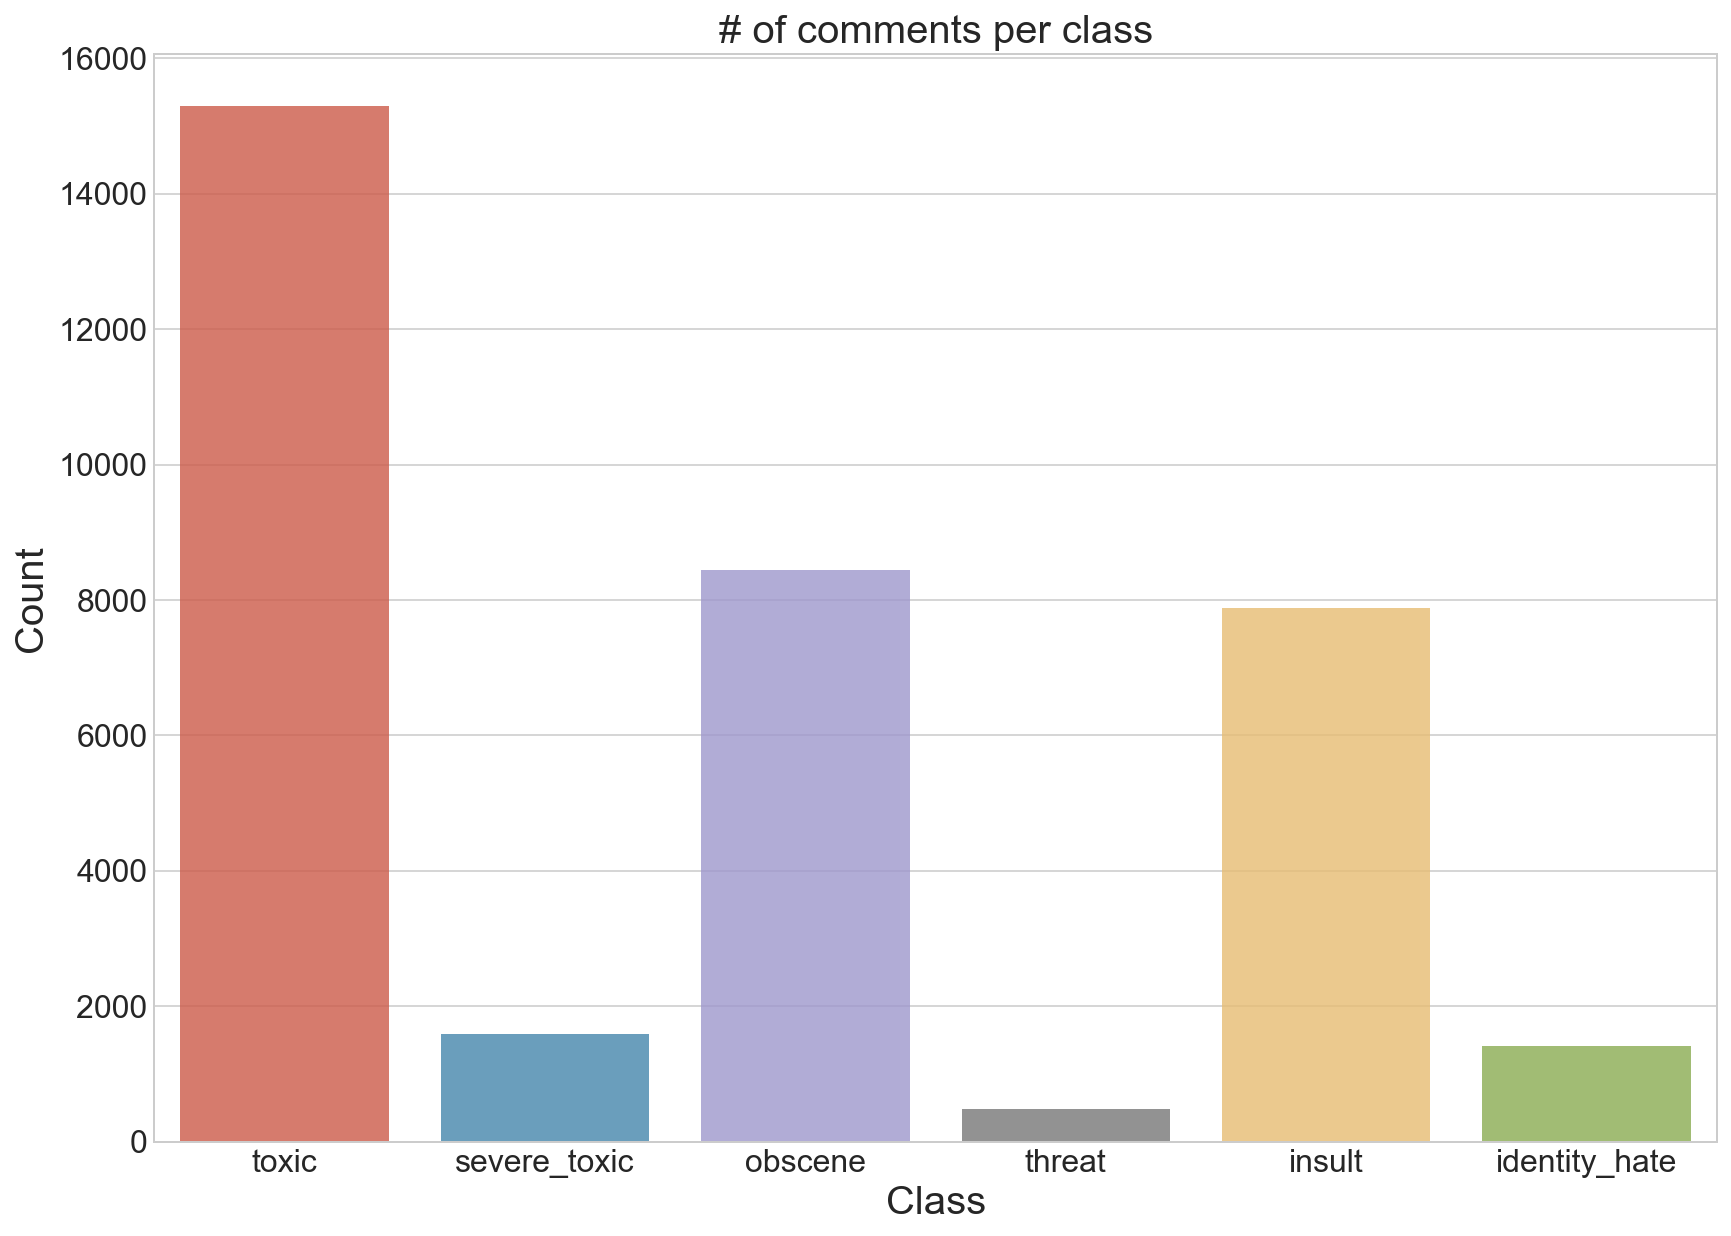

In [13]:
class_counts=data.iloc[:,2:].sum()
# print(class_counts)
sns.mpl.pyplot.figure(figsize=(14, 10))
sns.mpl.pyplot.title("# of comments per class", fontsize=20)
sns.mpl.pyplot.ylabel('Count')
sns.mpl.pyplot.xlabel('Class')
sns.barplot(class_counts.index, class_counts.values, alpha=0.8);

#### Labels per comment 

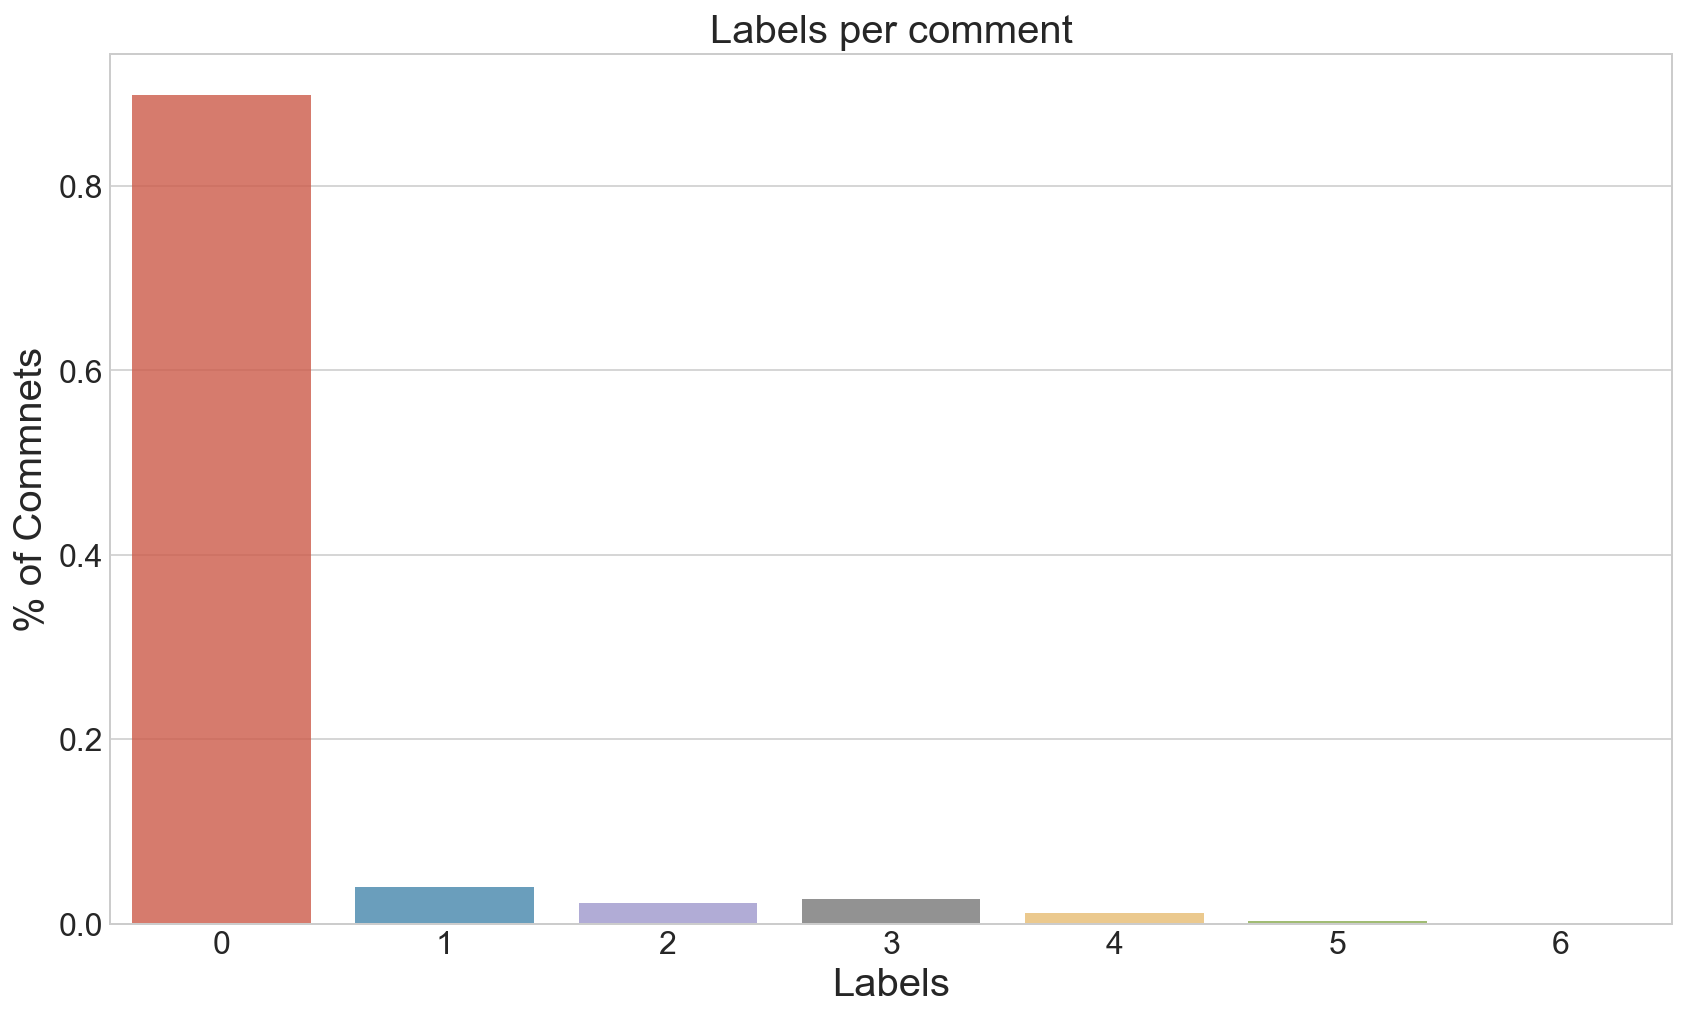

In [14]:
multi_tags=data.sum(axis=1).value_counts(normalize=True)
sns.mpl.pyplot.figure(figsize=(14, 8))
sns.mpl.pyplot.title("Labels per comment", fontsize=20)
sns.mpl.pyplot.ylabel('% of Commnets')
sns.mpl.pyplot.xlabel('Labels')
sns.barplot(multi_tags.index, multi_tags.values, alpha=0.8);

#### Top 20 word frequencies 

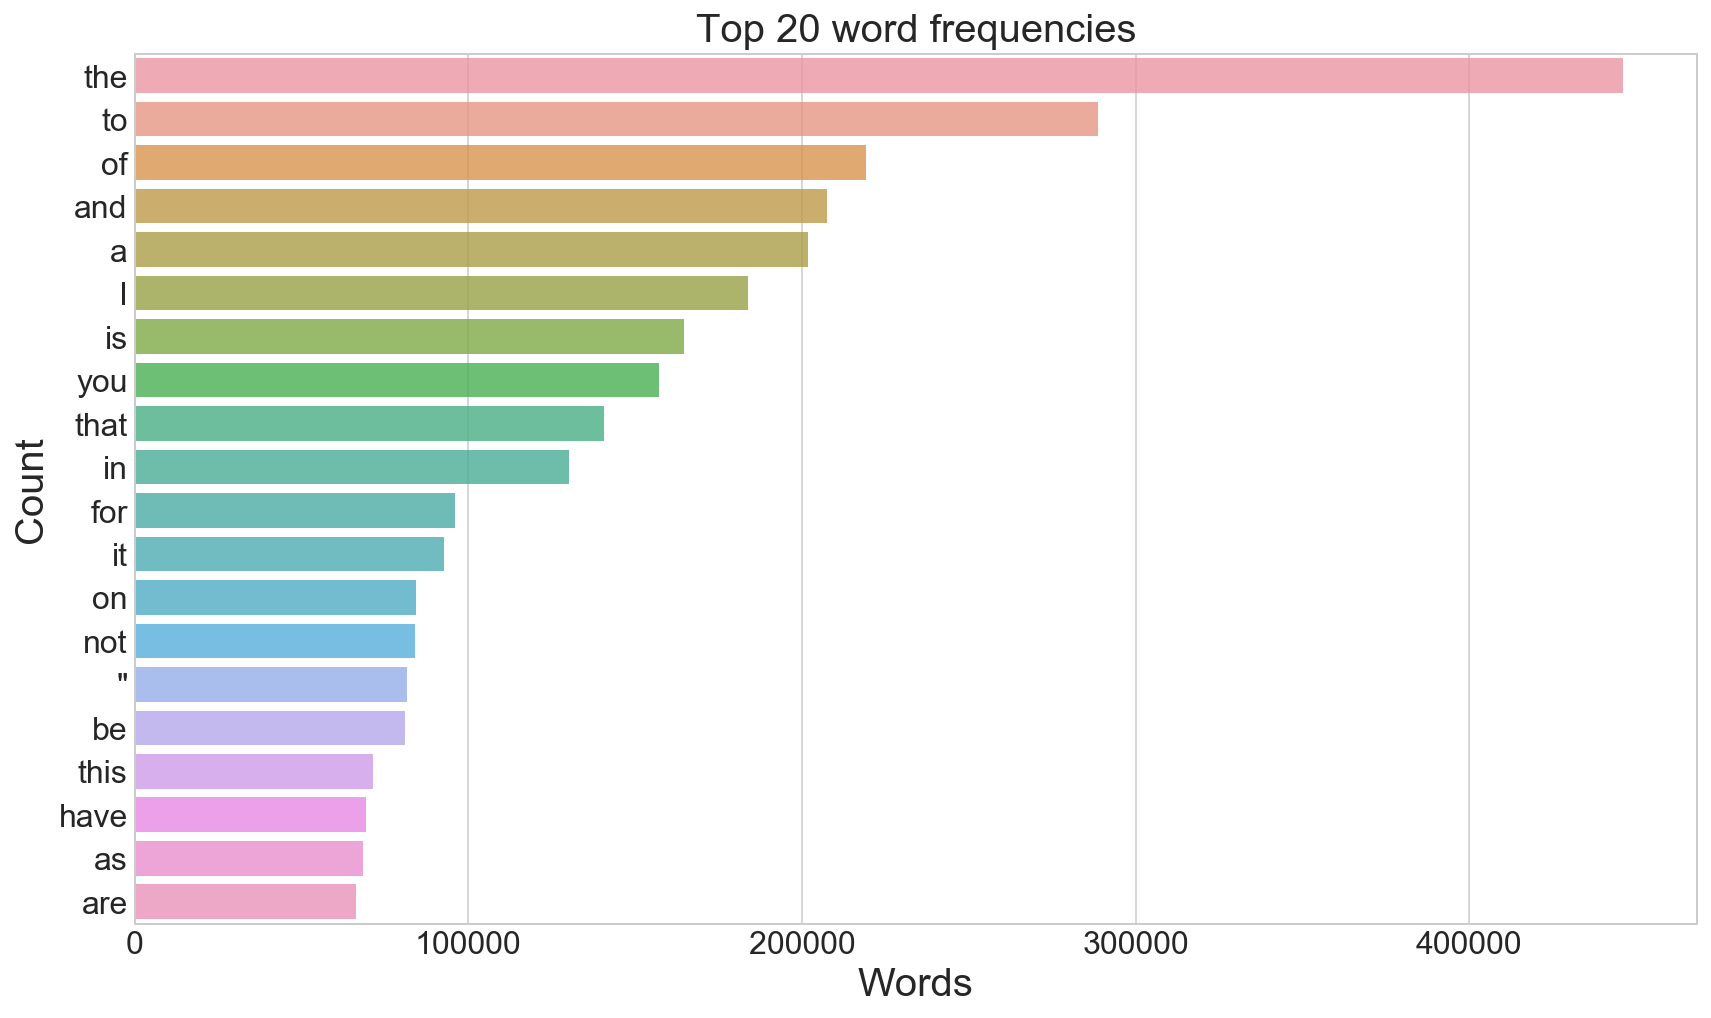

In [15]:
all_words = data['comment_text'].str.split(expand=True).unstack().value_counts().sort_values(ascending=False).head(20)
sns.mpl.pyplot.figure(figsize=(14, 8))
sns.mpl.pyplot.title("Top 20 word frequencies", fontsize=20)
sns.mpl.pyplot.ylabel('Count')
sns.mpl.pyplot.xlabel('Words')
sns.barplot(y=all_words.index, x=all_words.values, alpha=0.8,);

#### Function that accepts ***text*** and ***title*** as arguments and displays word cloud based on those values

In [380]:
def word_cloud(text,title,bg):
    wc= WordCloud(background_color=bg,max_words=2000,stopwords=stop) #exclude stop words
    wc.generate(" ".join(text))   
    sns.mpl.pyplot.figure(figsize=(15, 15))
    sns.mpl.pyplot.title(title, fontsize=20)
    sns.mpl.pyplot.axis("off")
    sns.mpl.pyplot.imshow(wc.recolor(colormap='viridis', random_state=42), alpha=0.98)
    sns.mpl.pyplot.show()

#### Visualize words frequently appearing in comments

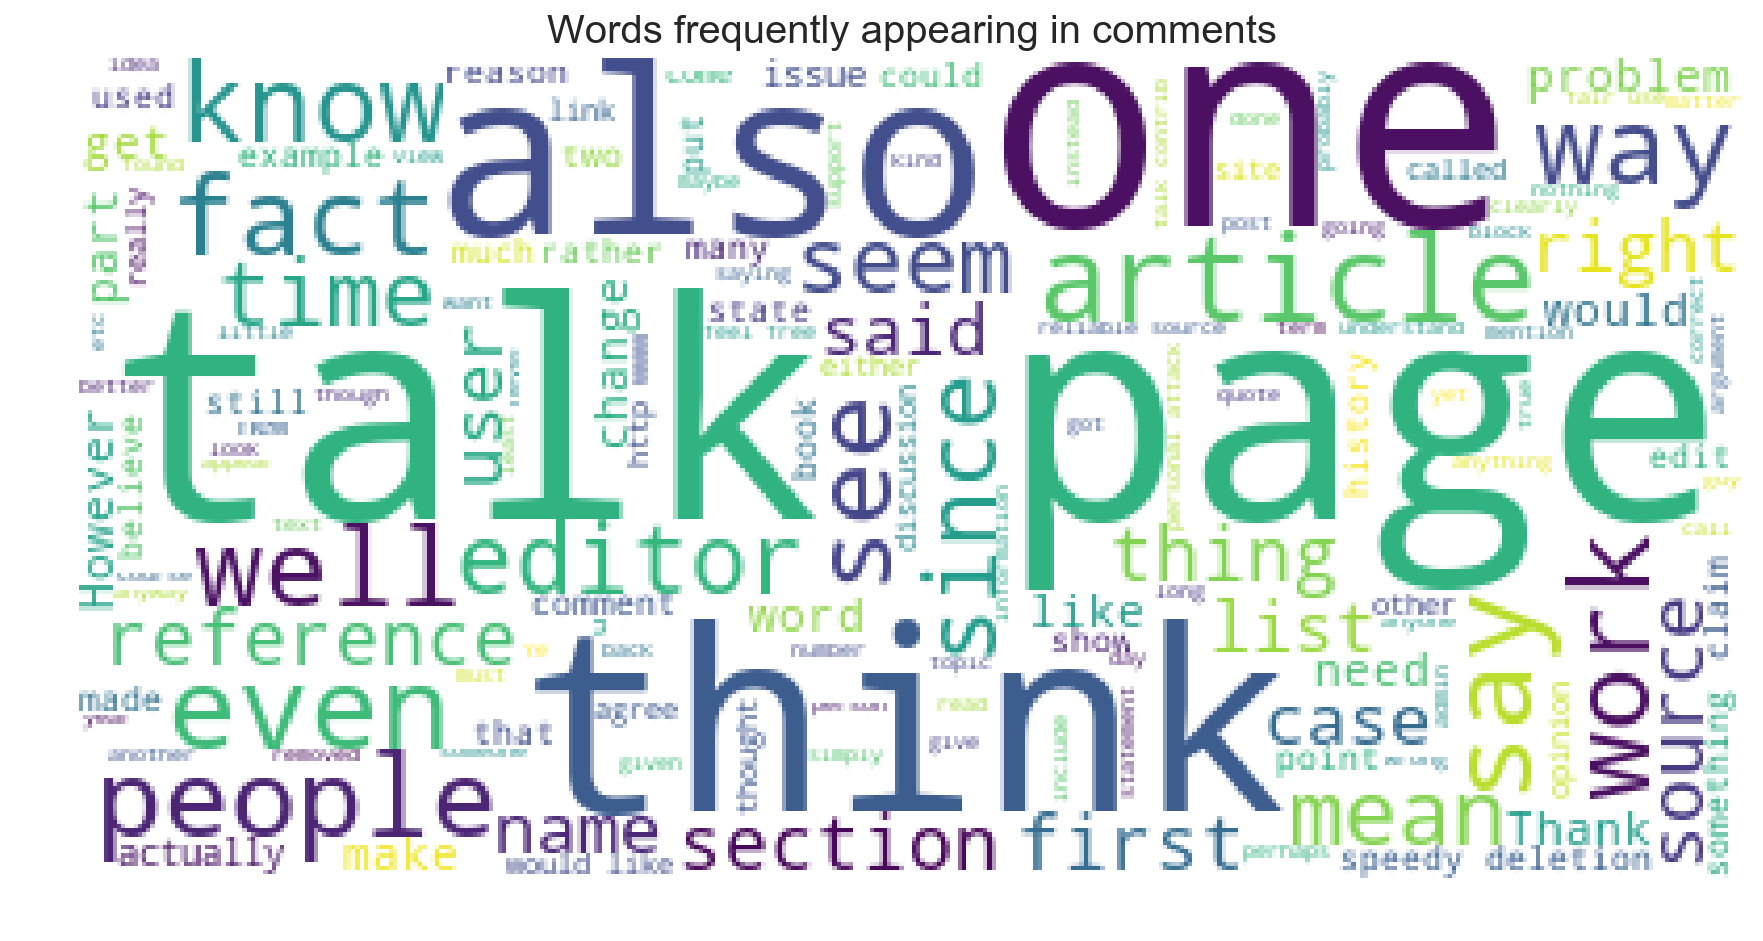

In [381]:
text = data['comment_text'].values
word_cloud(text,"Words frequently appearing in comments","white")

### CAUTION!!! -- you may find the following content *offensive*!

#### Visualize words frequently appearing in ***toxic*** comments

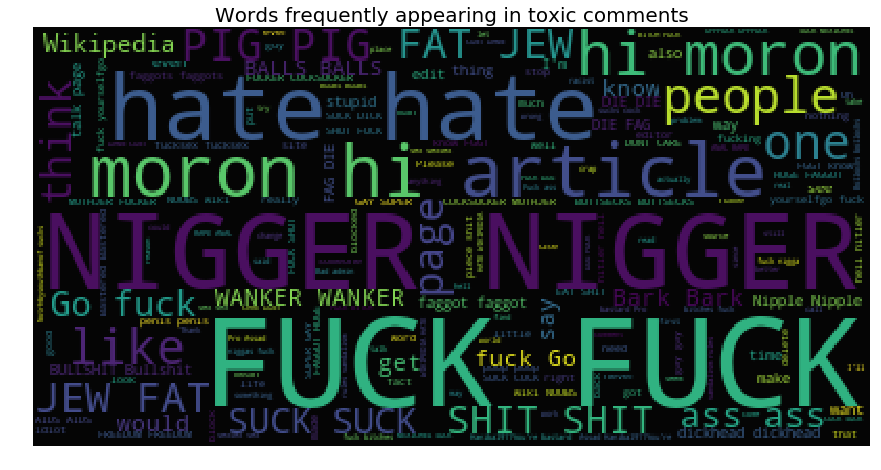

In [193]:
text = data[data["toxic"]==1]['comment_text'].values
word_cloud(text,"Words frequently appearing in toxic comments","black")

### CAUTION!!! -- you may find the following content *offensive*!

#### Visualize words frequently appearing in ***severely toxic*** comments

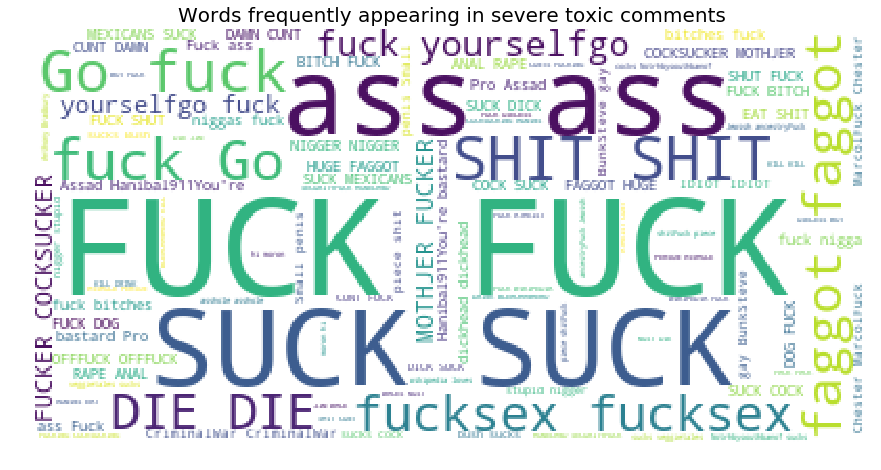

In [88]:
text = data[data["severe_toxic"]==1]['comment_text'].values
word_cloud(text,"Words frequently appearing in severe toxic comments","white")

### CAUTION!!! -- you may find the following content *offensive*!

#### Visualize words frequently appearing in ***threatening*** comments

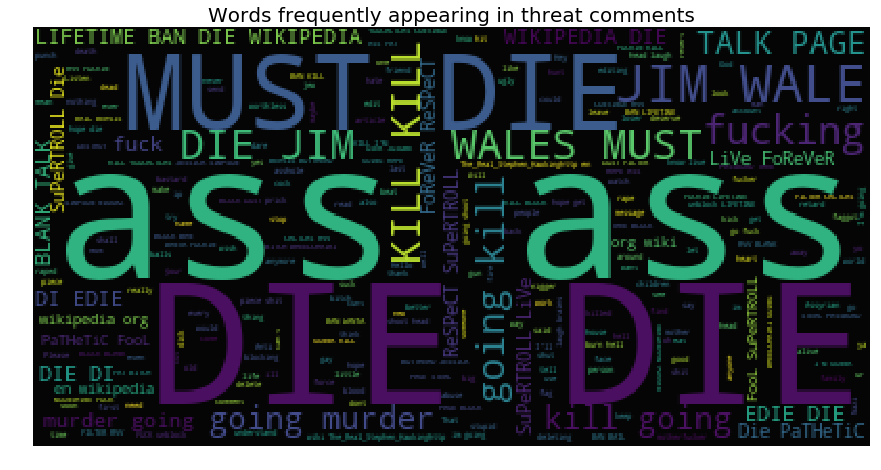

In [195]:
text = data[data["threat"]==1]['comment_text'].values
word_cloud(text,"Words frequently appearing in threat comments","black")

### CAUTION!!! -- you may find the following content *offensive*!

#### Visualize words frequently appearing in ***insulting*** comments

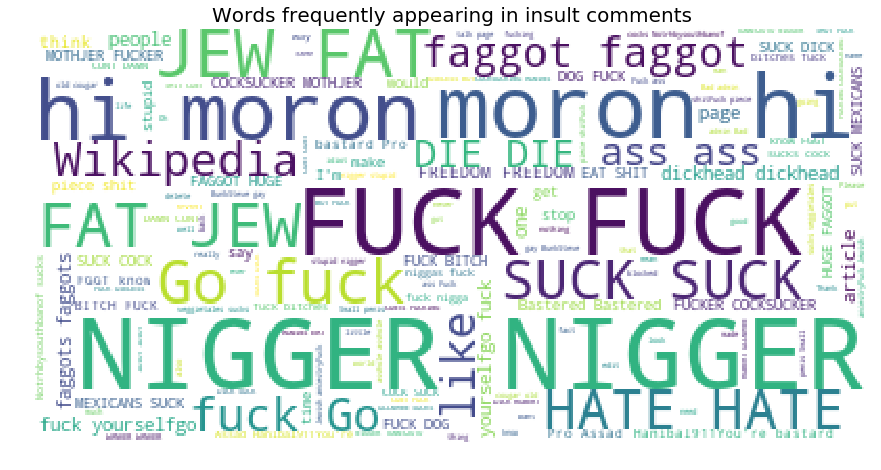

In [89]:
text = data[data["insult"]==1]['comment_text'].values
word_cloud(text,"Words frequently appearing in insult comments","white")

### CAUTION!!! -- you may find the following content *offensive*!

#### Visualize words frequently appearing in ***obscene*** comments

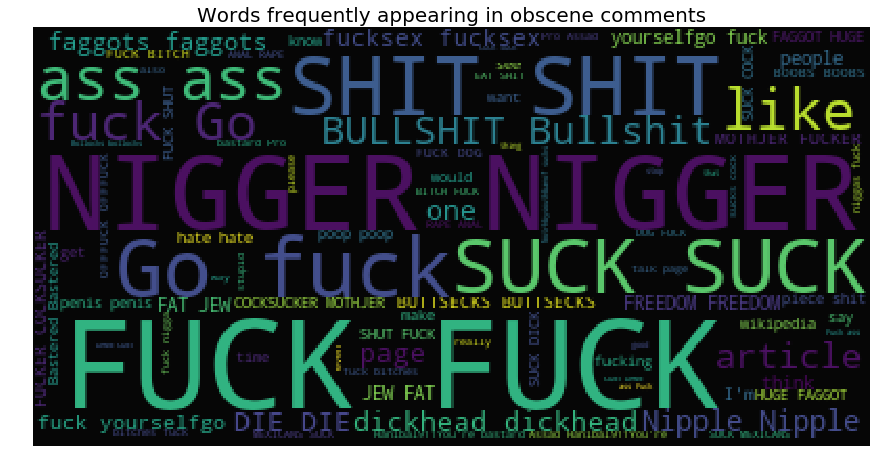

In [94]:
text = data[data["obscene"]==1]['comment_text'].values
word_cloud(text,"Words frequently appearing in obscene comments","black")

### CAUTION!!! -- you may find the following content *offensive*!

#### Visualize words frequently appearing in ***hateful*** comments

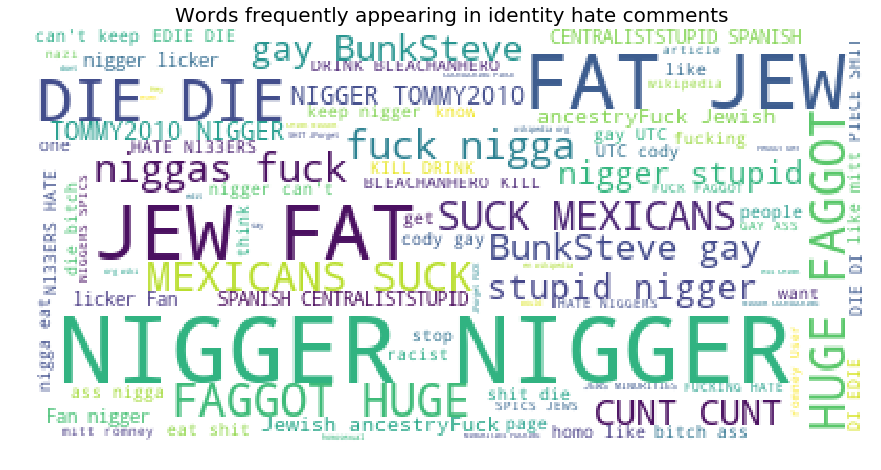

In [91]:
text = data[data["identity_hate"]==1]['comment_text'].values
word_cloud(text,"Words frequently appearing in identity hate comments","white")

##### **Observation**: As one would imagine, most of the (curse) words are common among toxic, severe toxic, insulting and obscene comments and there’s a clear distinction between words more common in threatening and hateful comments.

## Feature Engineering

### Generate features that we might be able to use during model creating 

#### Sentences count in each comment

In [382]:
#Sentences count in each comment
data['sentence_cnt'] = data["comment_text"].apply(lambda comment: len(re.findall("\n",str(comment)))+1)

#### Words count in each comment

In [383]:
#Words count in each comment
data['word_cnt'] = data["comment_text"].apply(lambda comment: len(str(comment).split()))

#### Unique words count in each comment

In [384]:
#Unique words count in each comment
data['unique_word_cnt'] = data["comment_text"].apply(lambda comment: len(set(str(comment).split())))

#### Stop words count in each comment

In [385]:
#Stop words count in each comment
data["stopwords_cnt"] = data["comment_text"].apply(lambda comment: len([word for word in str(comment).lower().split() if word in stop]))

#### Examine data

In [386]:
#Examine new features
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sentence_cnt,word_cnt,unique_word_cnt,stopwords_cnt
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0,2,43,41,18
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0,1,17,17,2
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0,1,42,39,20
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,0,0,0,0,0,5,113,82,56
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0,1,13,13,5


### Elements that may introduce ***leakage*** such as IP addresses, links, usernames, etc. found in comments

#### IP Addresses

In [387]:
#IP addresses
data['ip'] = data["comment_text"].apply(lambda x: re.findall("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",str(x)))

#Count of IP addresses
data['count_ip'] = data["ip"].apply(lambda x: len(x))

#### Links

In [388]:
#Links
data['link'] = data["comment_text"].apply(lambda x: re.findall("http://.*com",str(x)))

#Count of links
data['count_links'] = data["link"].apply(lambda x: len(x))

#### Article IDs

In [389]:
#Article ids
data['article_id'] = data["comment_text"].apply(lambda x: re.findall("\d:\d\d\s{0,5}$",str(x)))
data['article_id_flag'] = data.article_id.apply(lambda x: len(x))

#### Usernames

In [390]:
#Usernames
#Note: regex for Match anything with [[User: ---------- ]]
data['username'] = data["comment_text"].apply(lambda x: re.findall("\[\[User(.*)\|",str(x)))

#Count of username mentions
data['count_usernames'] = data["username"].apply(lambda x: len(x))

#### Examine data

In [391]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sentence_cnt,word_cnt,unique_word_cnt,stopwords_cnt,ip,count_ip,link,count_links,article_id,article_id_flag,username,count_usernames
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0,2,43,41,18,[89.205.38.27],1,[],0,[],0,[],0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0,1,17,17,2,[],0,[],0,[],0,[],0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0,1,42,39,20,[],0,[],0,[],0,[],0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,0,0,0,0,0,5,113,82,56,[],0,[],0,[],0,[],0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0,1,13,13,5,[],0,[],0,[],0,[],0


### Distribution of comments _with_ links, IPs, usernames vs. comments _without_ links, IPs, usernames

#### Setup subset of data

In [392]:
comments_with_links = data[data['count_links'] > 0]
comments_with_no_links = data[data['count_links'] == 0]

comments_with_usernames = data[data['count_usernames'] > 0]
comments_with_no_usernames = data[data['count_usernames'] == 0]

comments_with_ips = data[data['count_ip'] > 0]
comments_with_no_ips = data[data['count_ip'] == 0]

#### Distribution of comments with and without links 

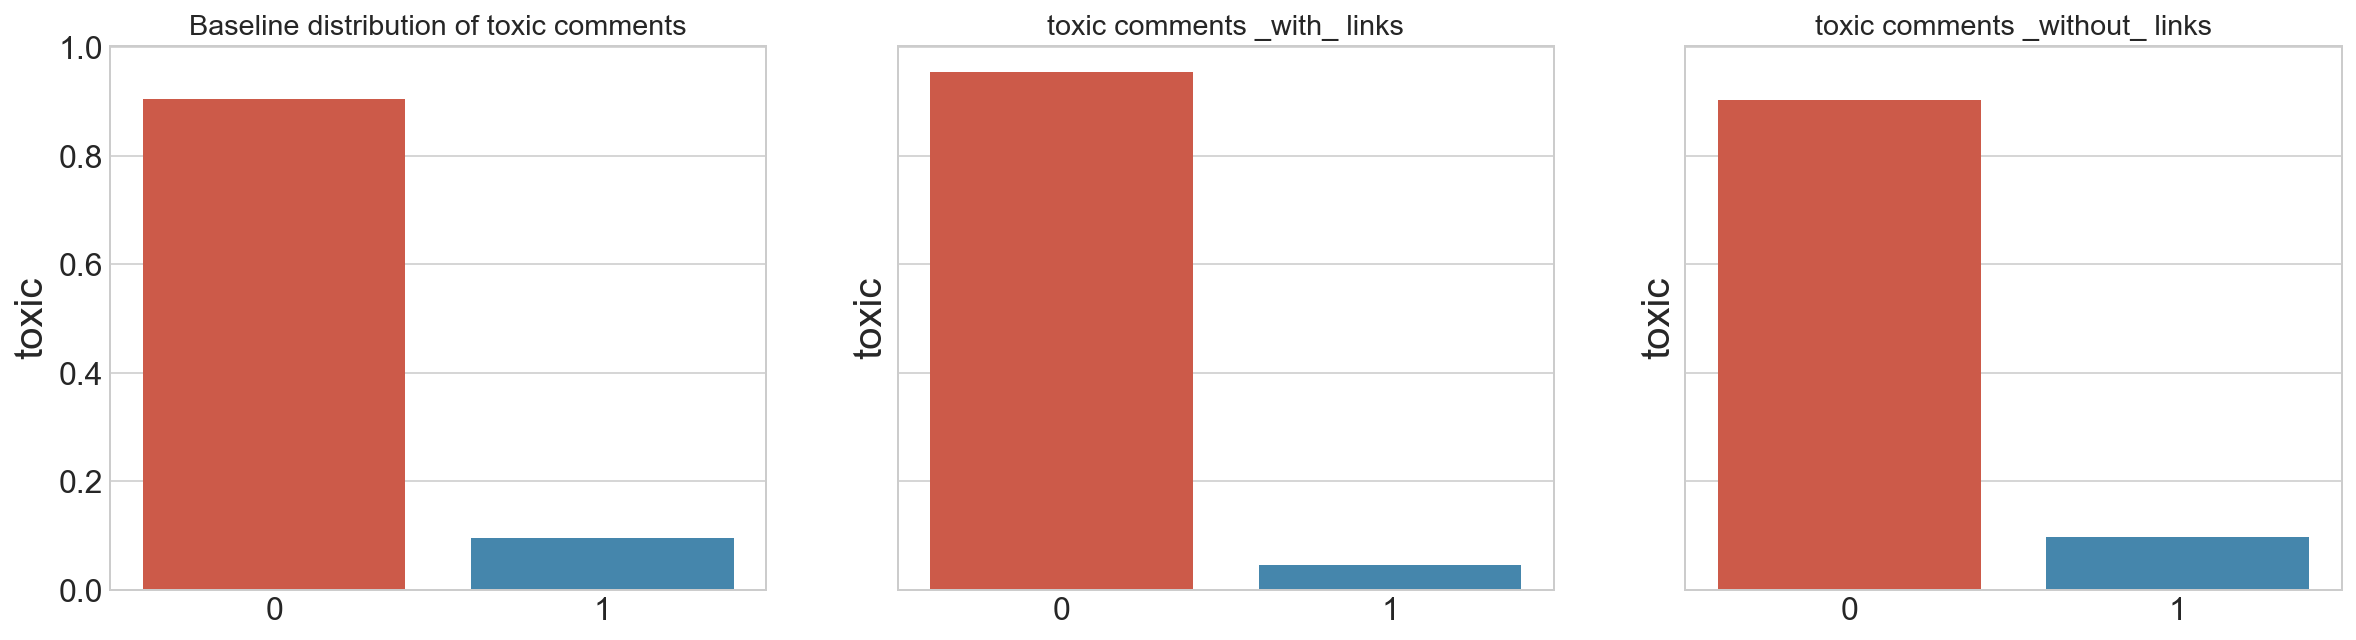

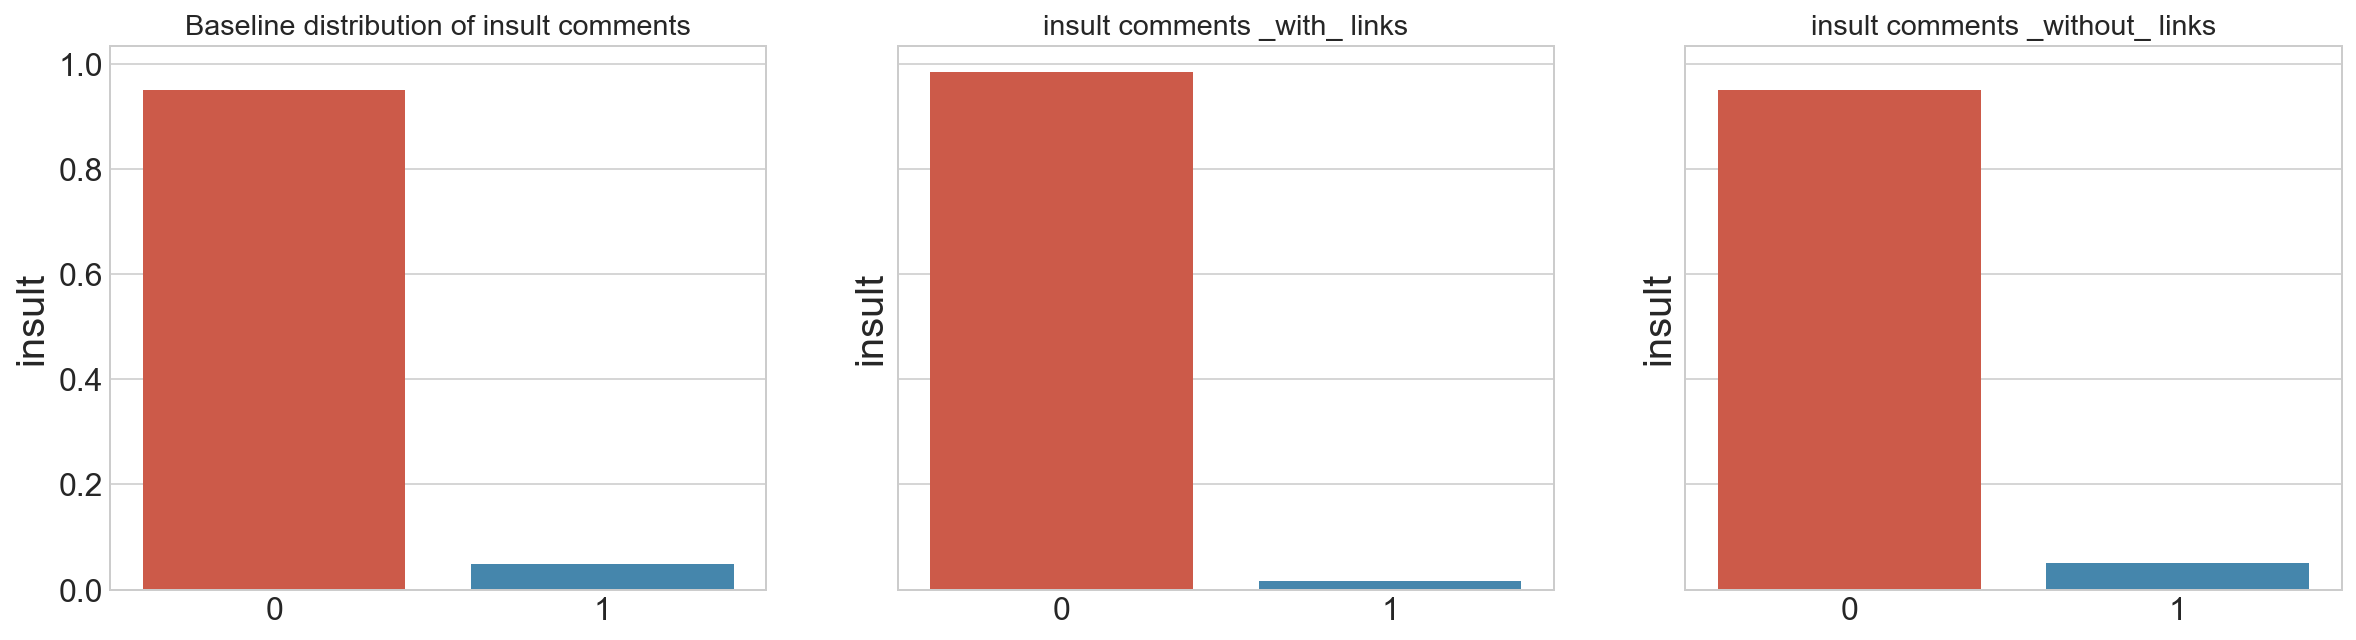

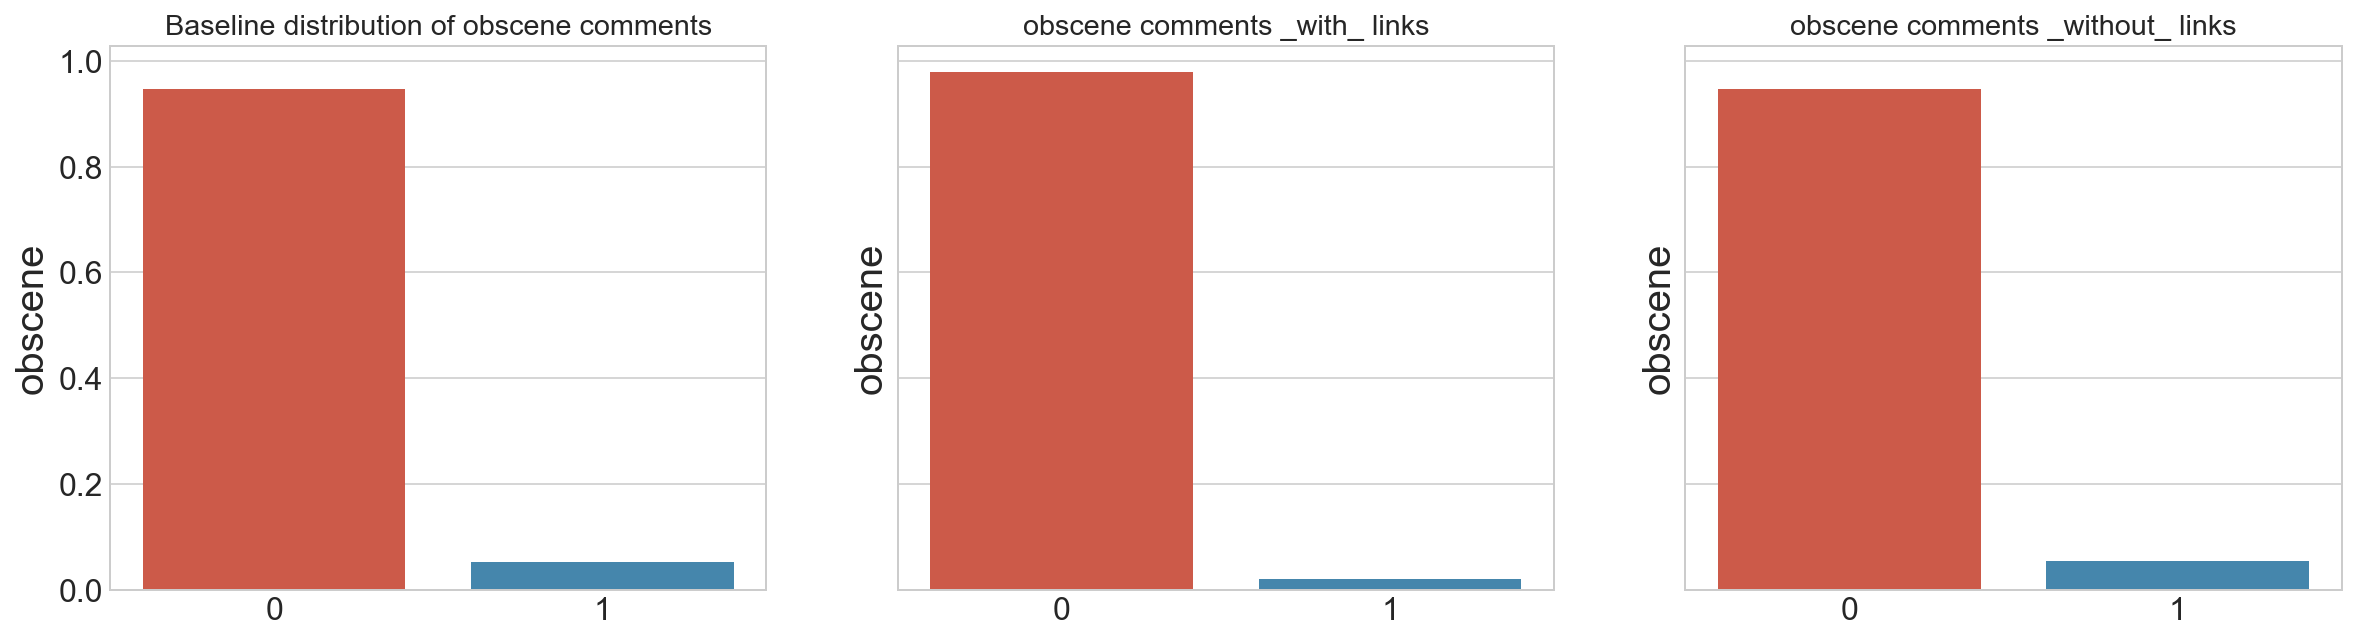

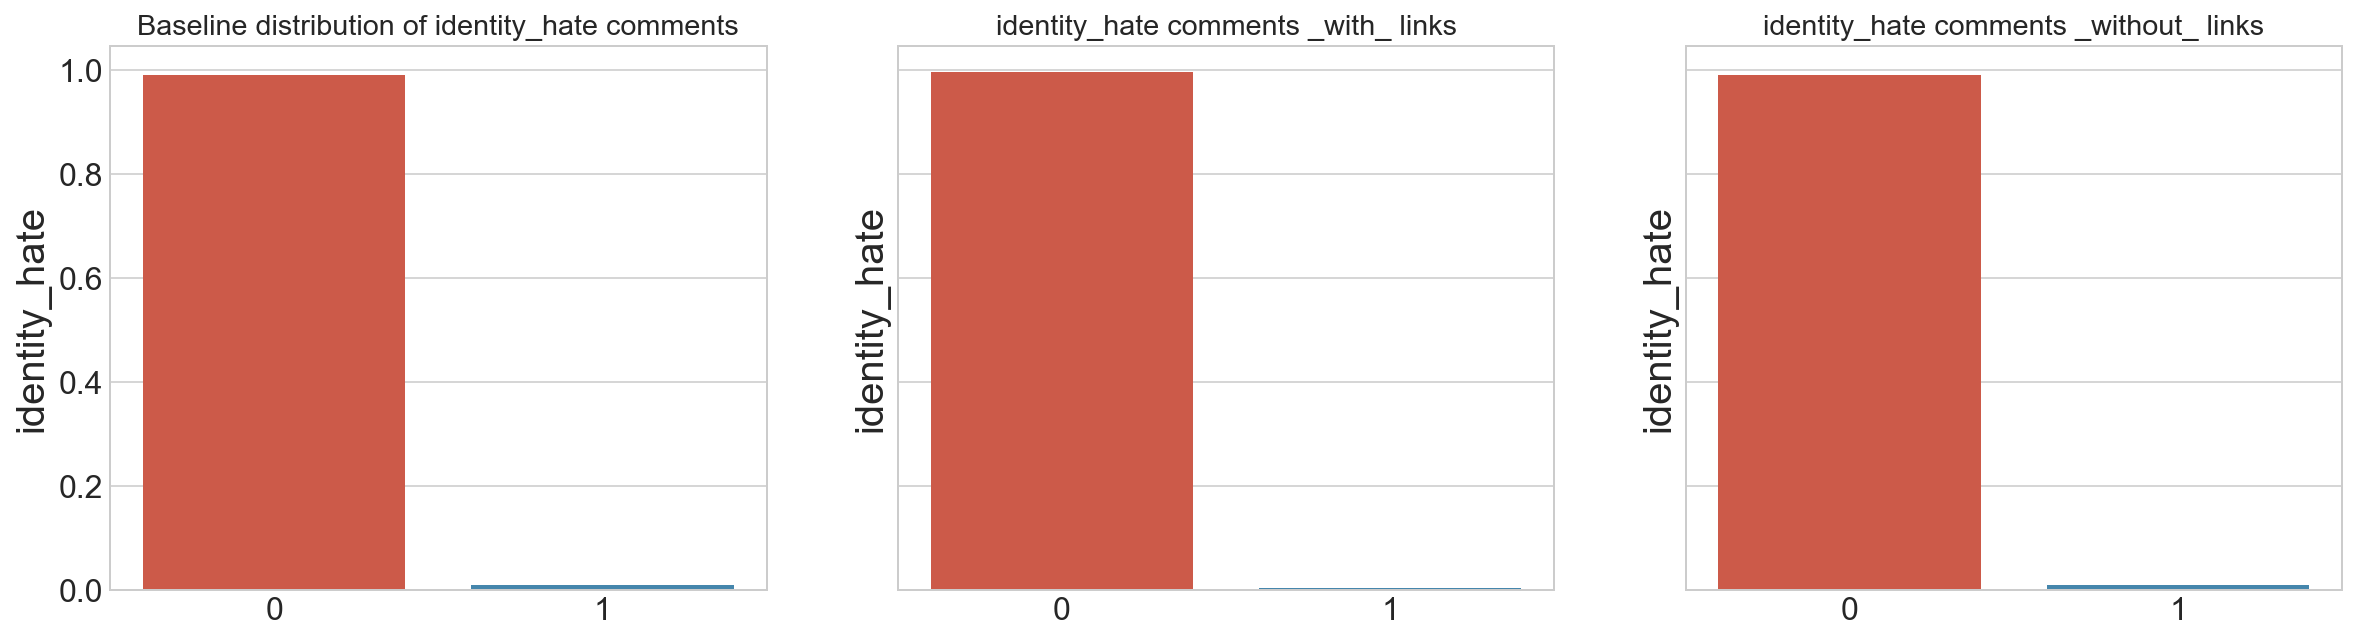

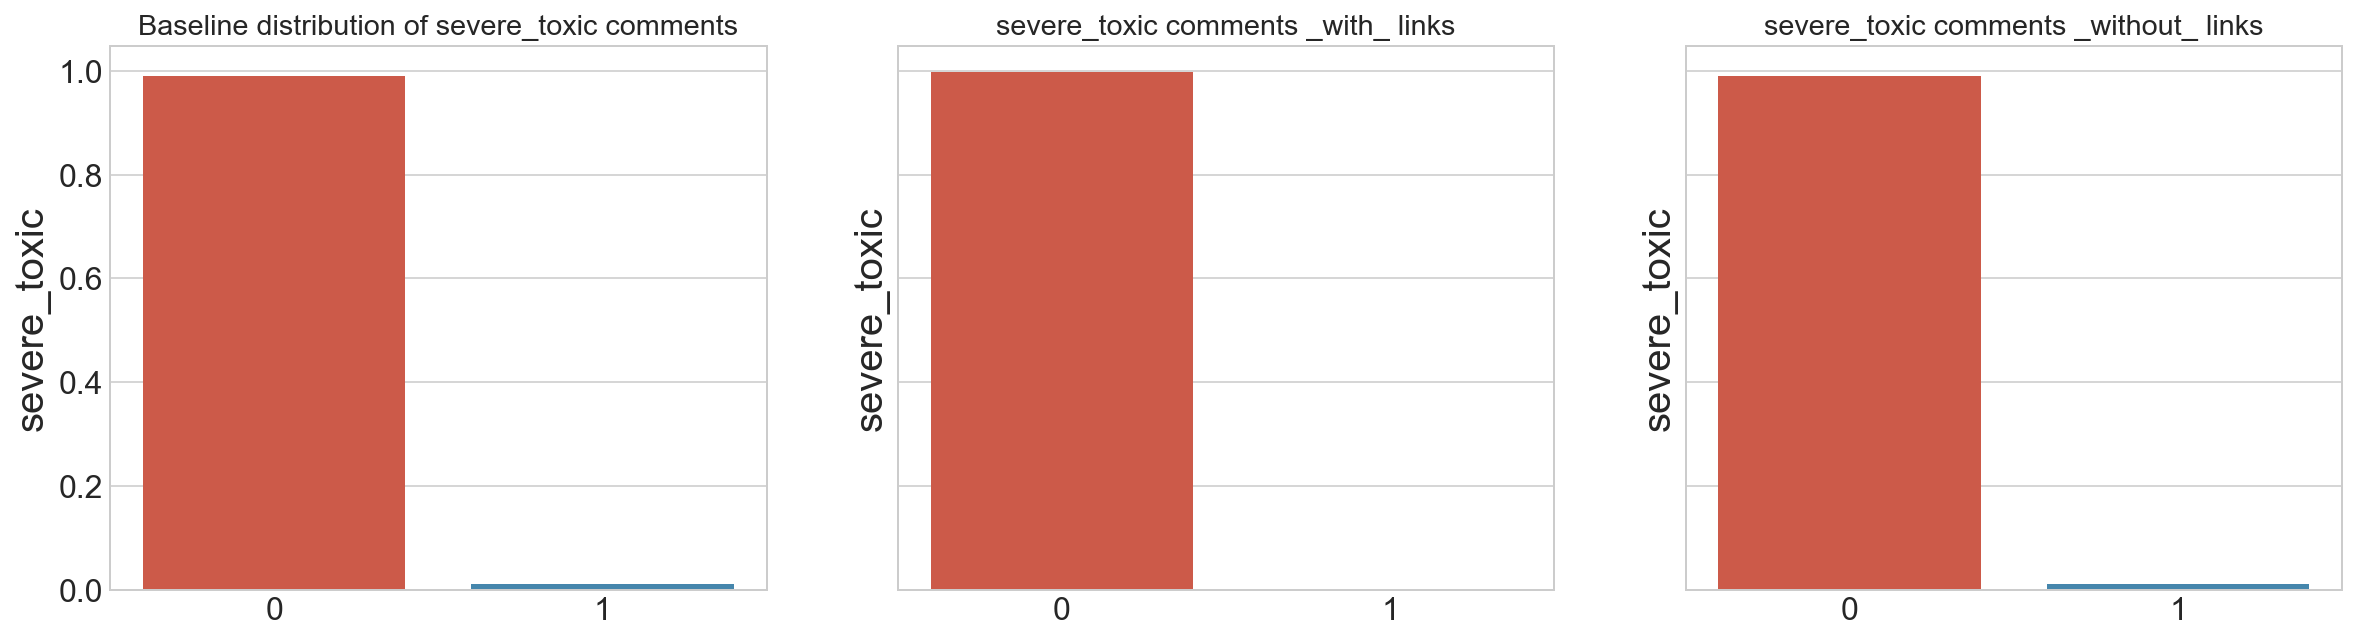

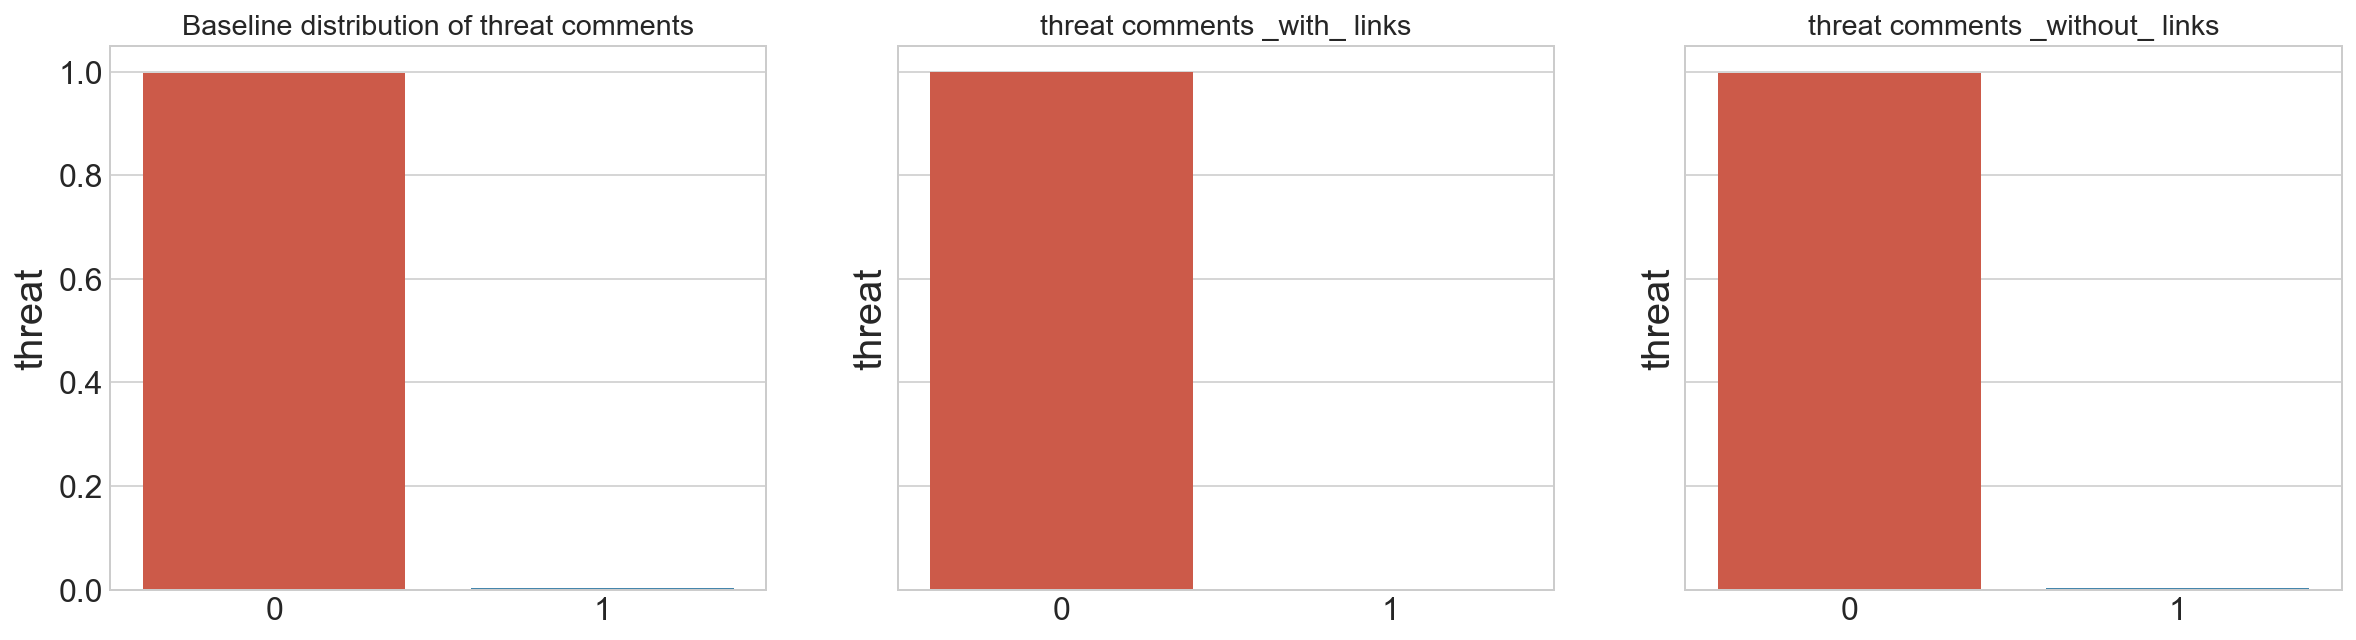

In [393]:
for target in targets:
    f, (ax1, ax2, ax3) = sns.mpl.pyplot.subplots(1, 3, figsize=(20,5), sharey="all")

    ax1.set_title("Baseline distribution of "+target+" comments")
    sns.barplot(x=data[target].value_counts().index, y=data[target].value_counts(normalize=True), ax=ax1)
    ax2.set_title(target+" comments _with_ links")
    sns.barplot(x=comments_with_links[target].value_counts().index, y=comments_with_links[target].value_counts(normalize=True), ax=ax2)
    ax3.set_title(target+" comments _without_ links")
    sns.barplot(x=comments_with_no_links[target].value_counts().index, y=comments_with_no_links[target].value_counts(normalize=True), ax=ax3);

#### Distribution of comments with and without usernames 

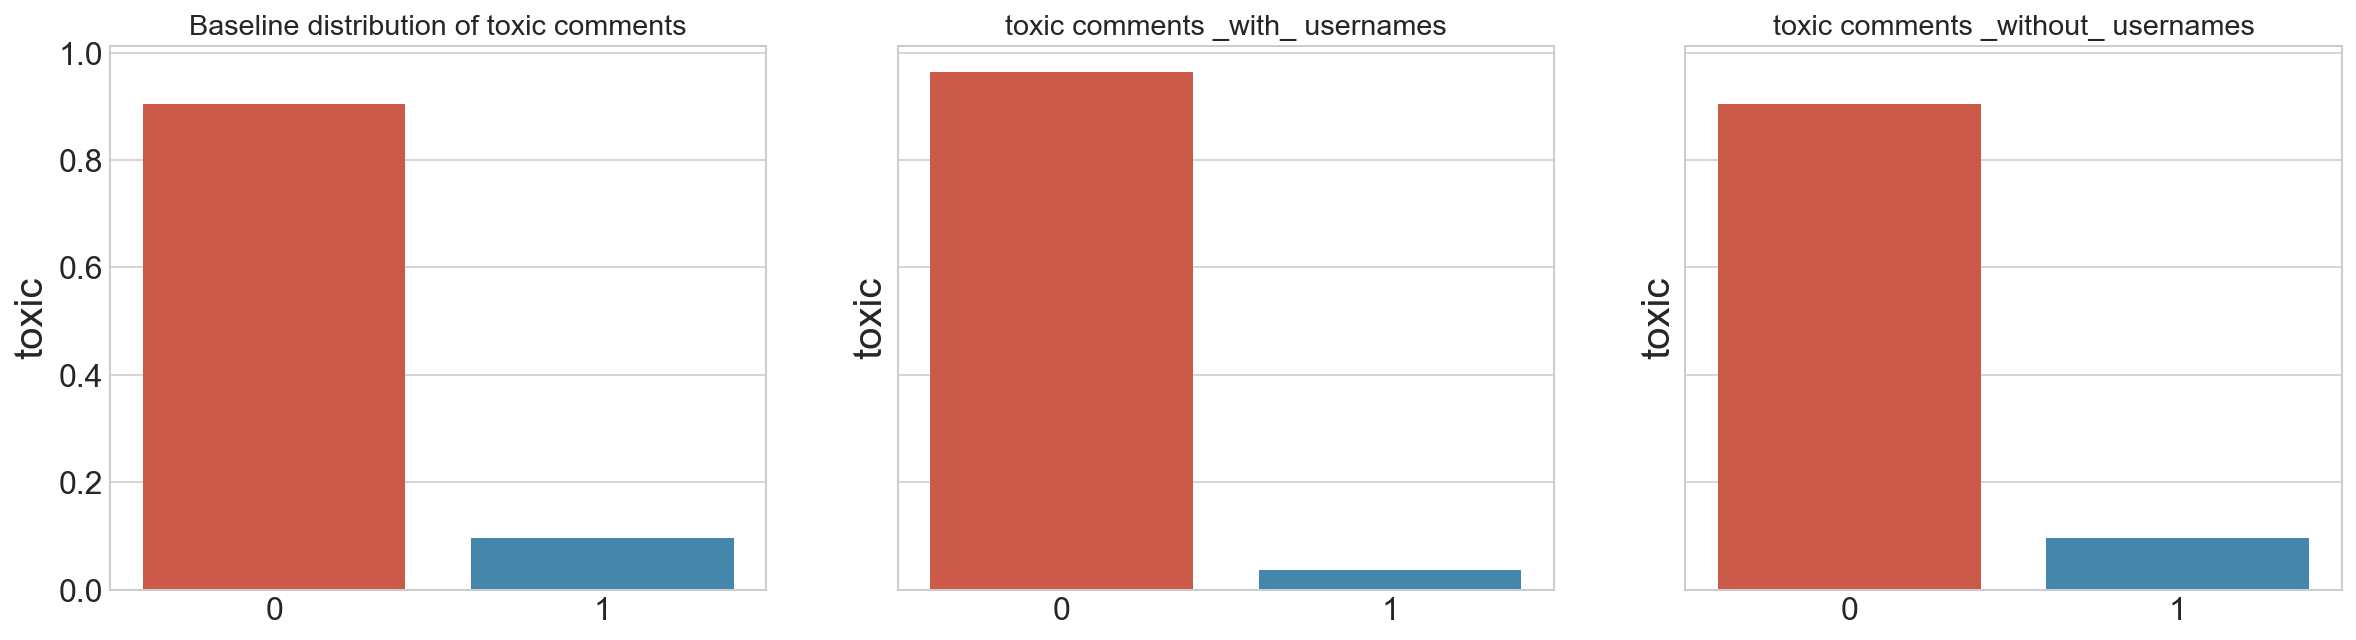

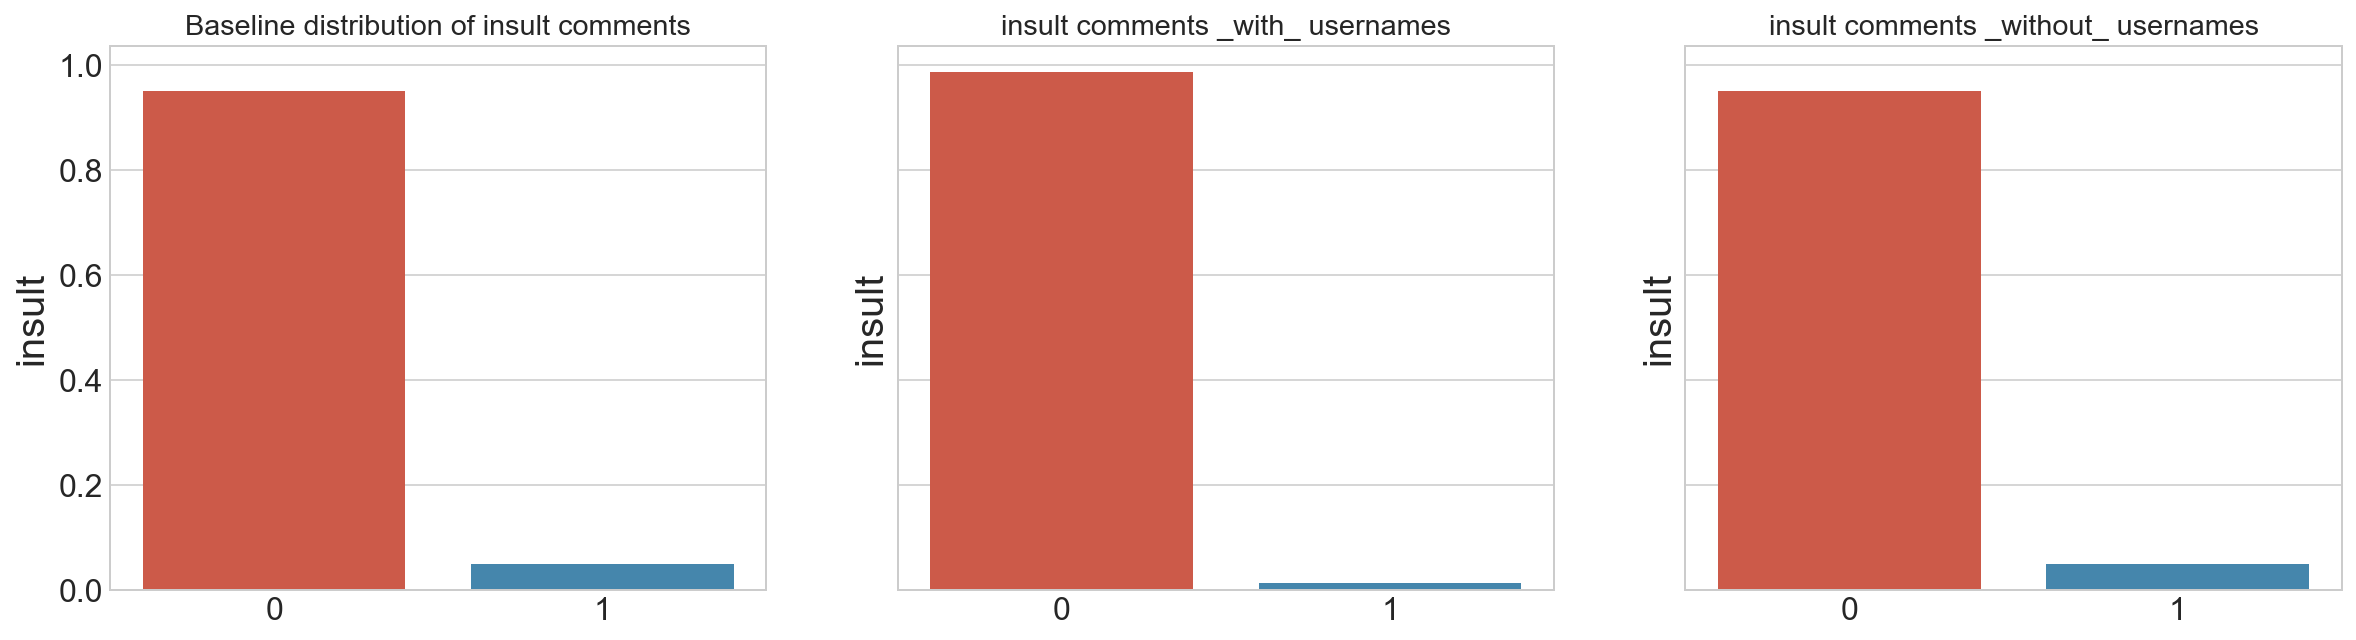

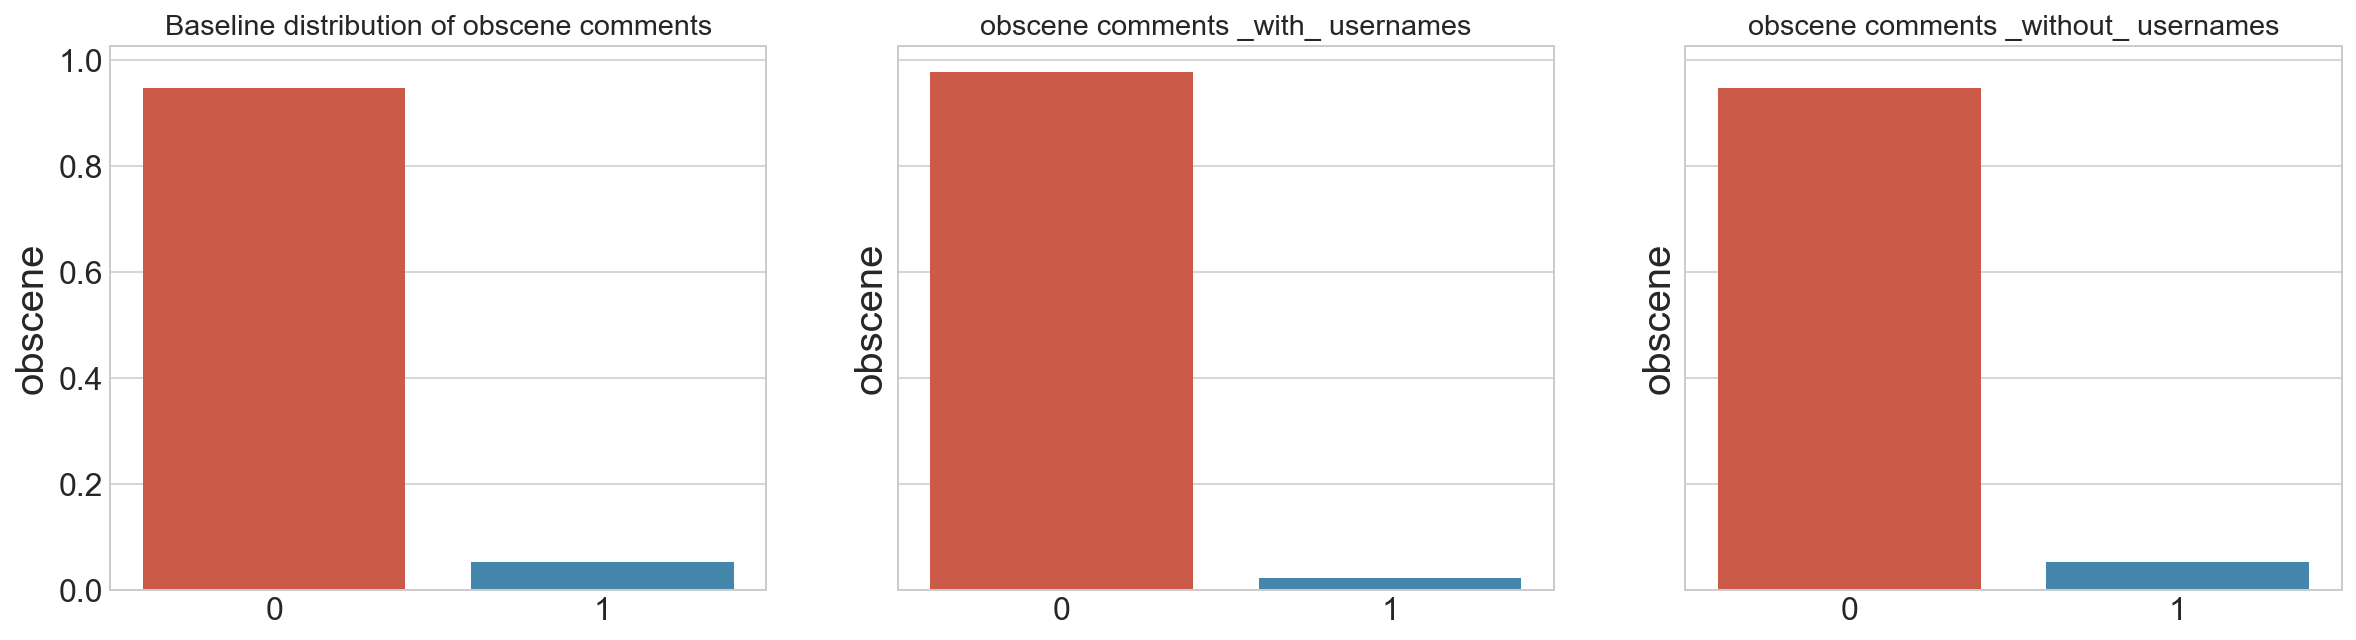

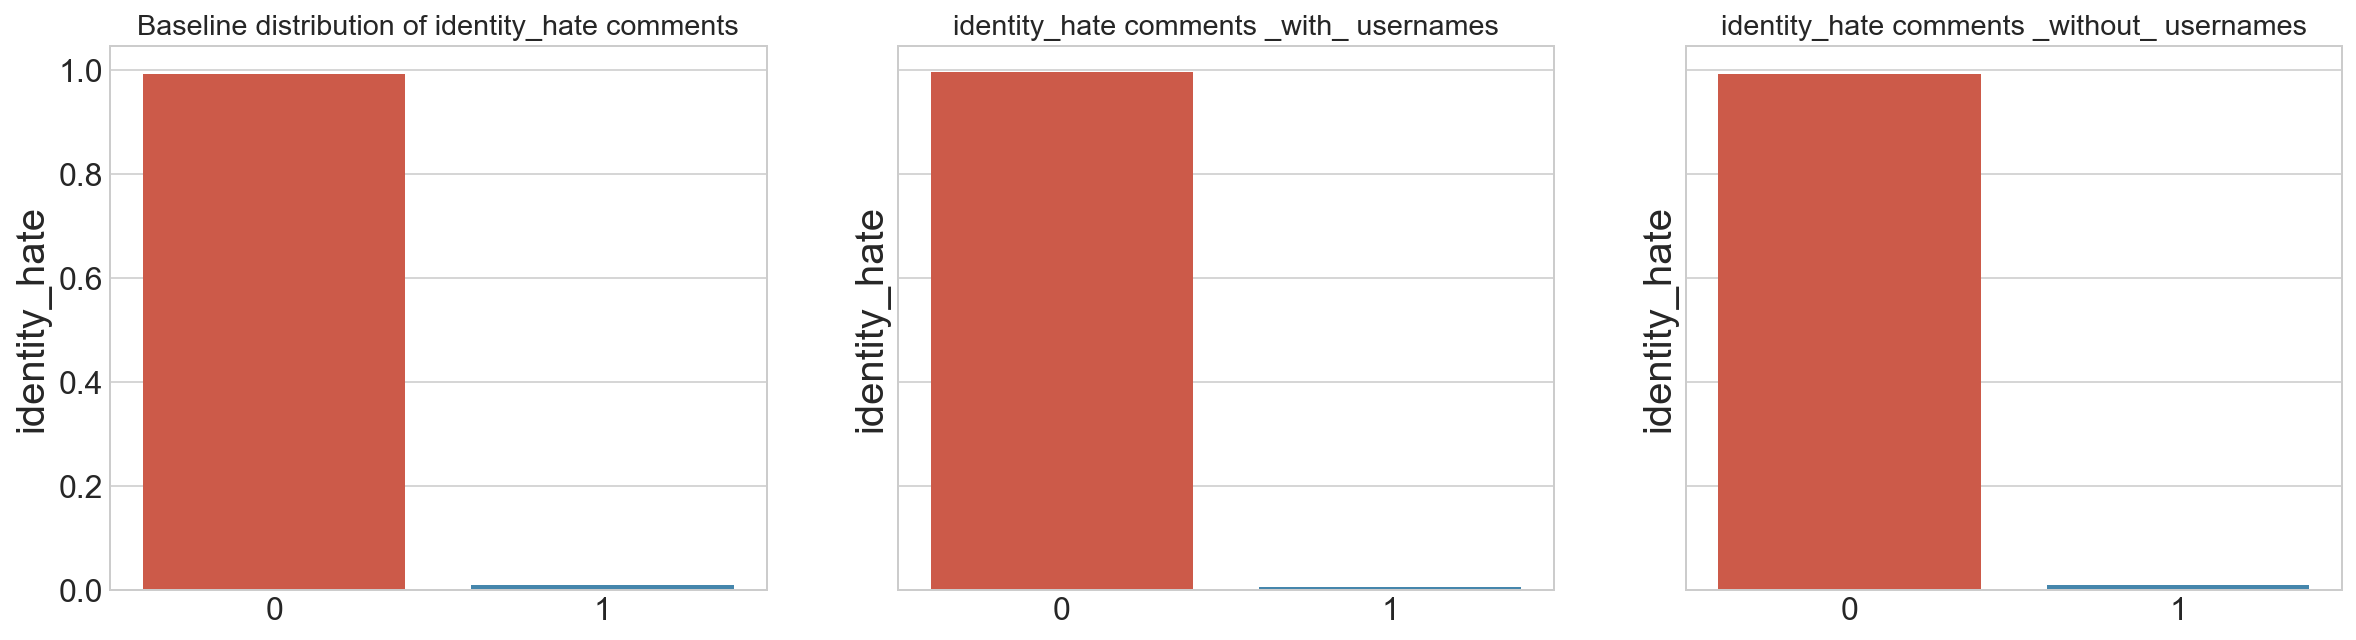

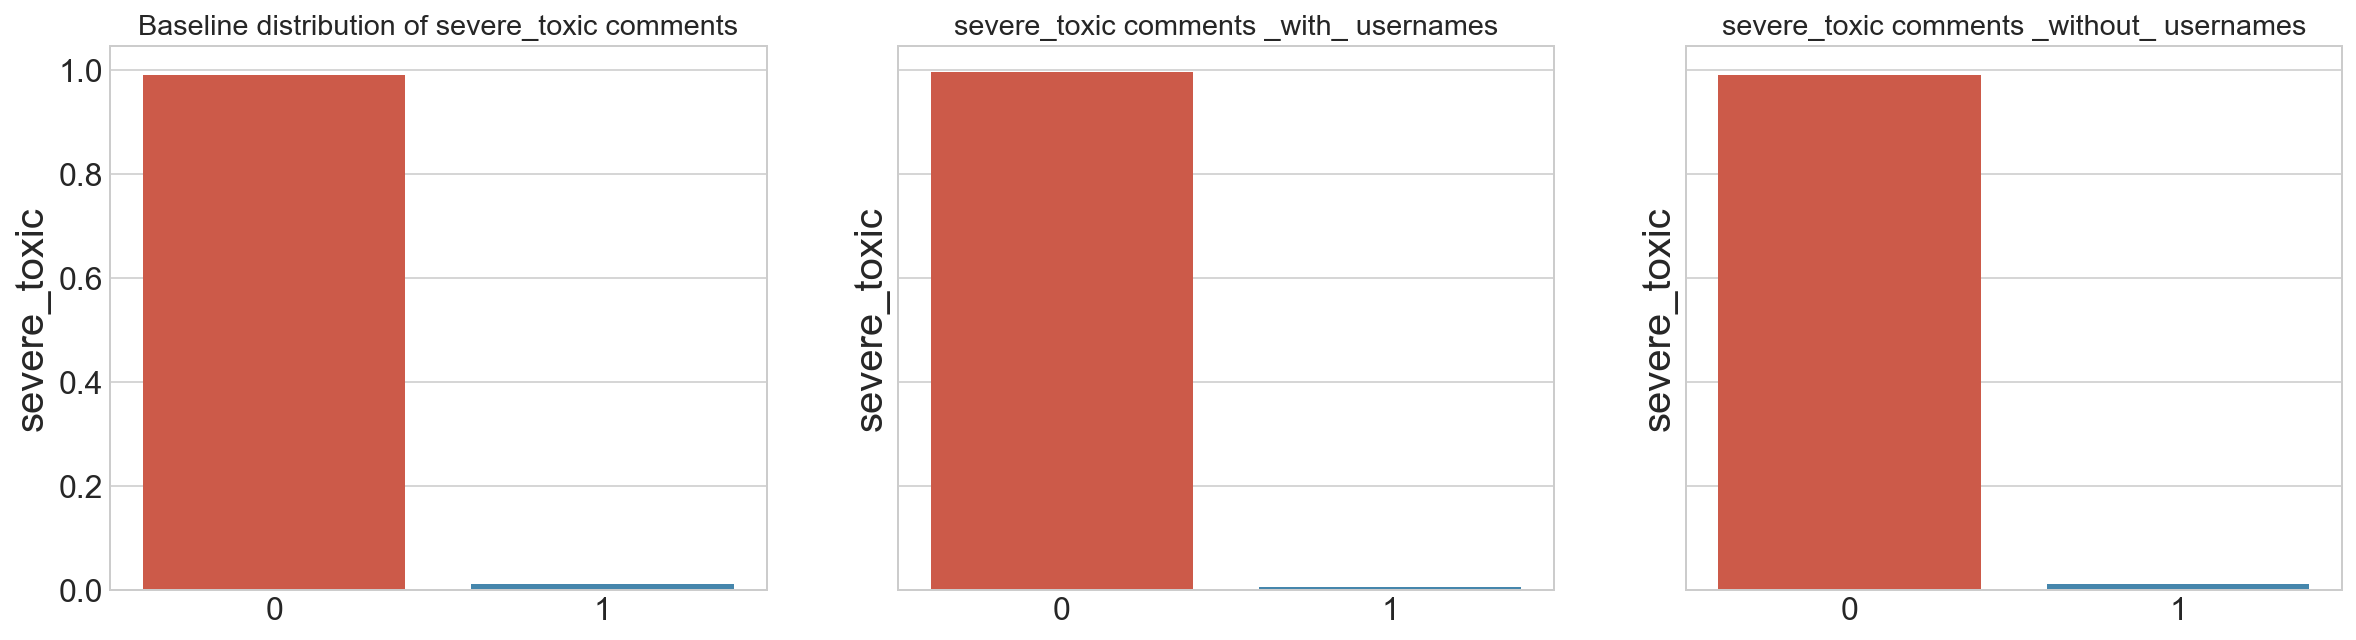

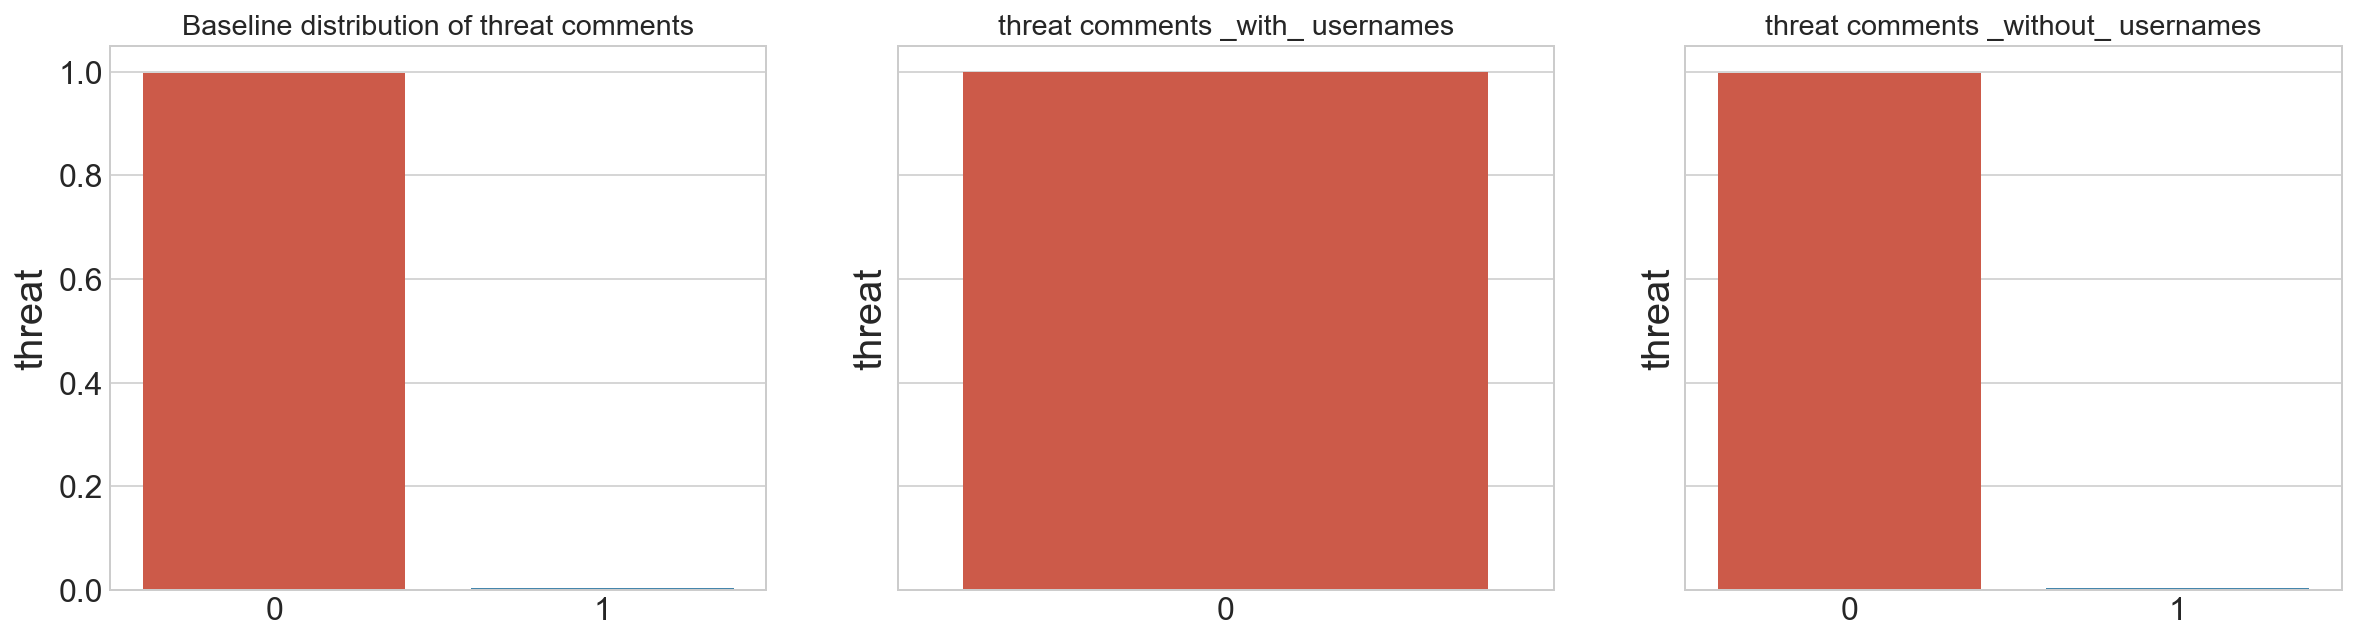

In [394]:
for target in targets:
    f, (ax1, ax2, ax3) = sns.mpl.pyplot.subplots(1, 3, figsize=(20,5), sharey="all")

    ax1.set_title("Baseline distribution of "+target+" comments")
    sns.barplot(x=data[target].value_counts().index, y=data[target].value_counts(normalize=True), ax=ax1)
    ax2.set_title(target+" comments _with_ usernames")
    sns.barplot(x=comments_with_usernames[target].value_counts().index, y=comments_with_usernames[target].value_counts(normalize=True), ax=ax2)
    ax3.set_title(target+" comments _without_ usernames")
    sns.barplot(x=comments_with_no_usernames[target].value_counts().index, y=comments_with_no_usernames[target].value_counts(normalize=True), ax=ax3);

#### Distribution of comments with and without IP addresses

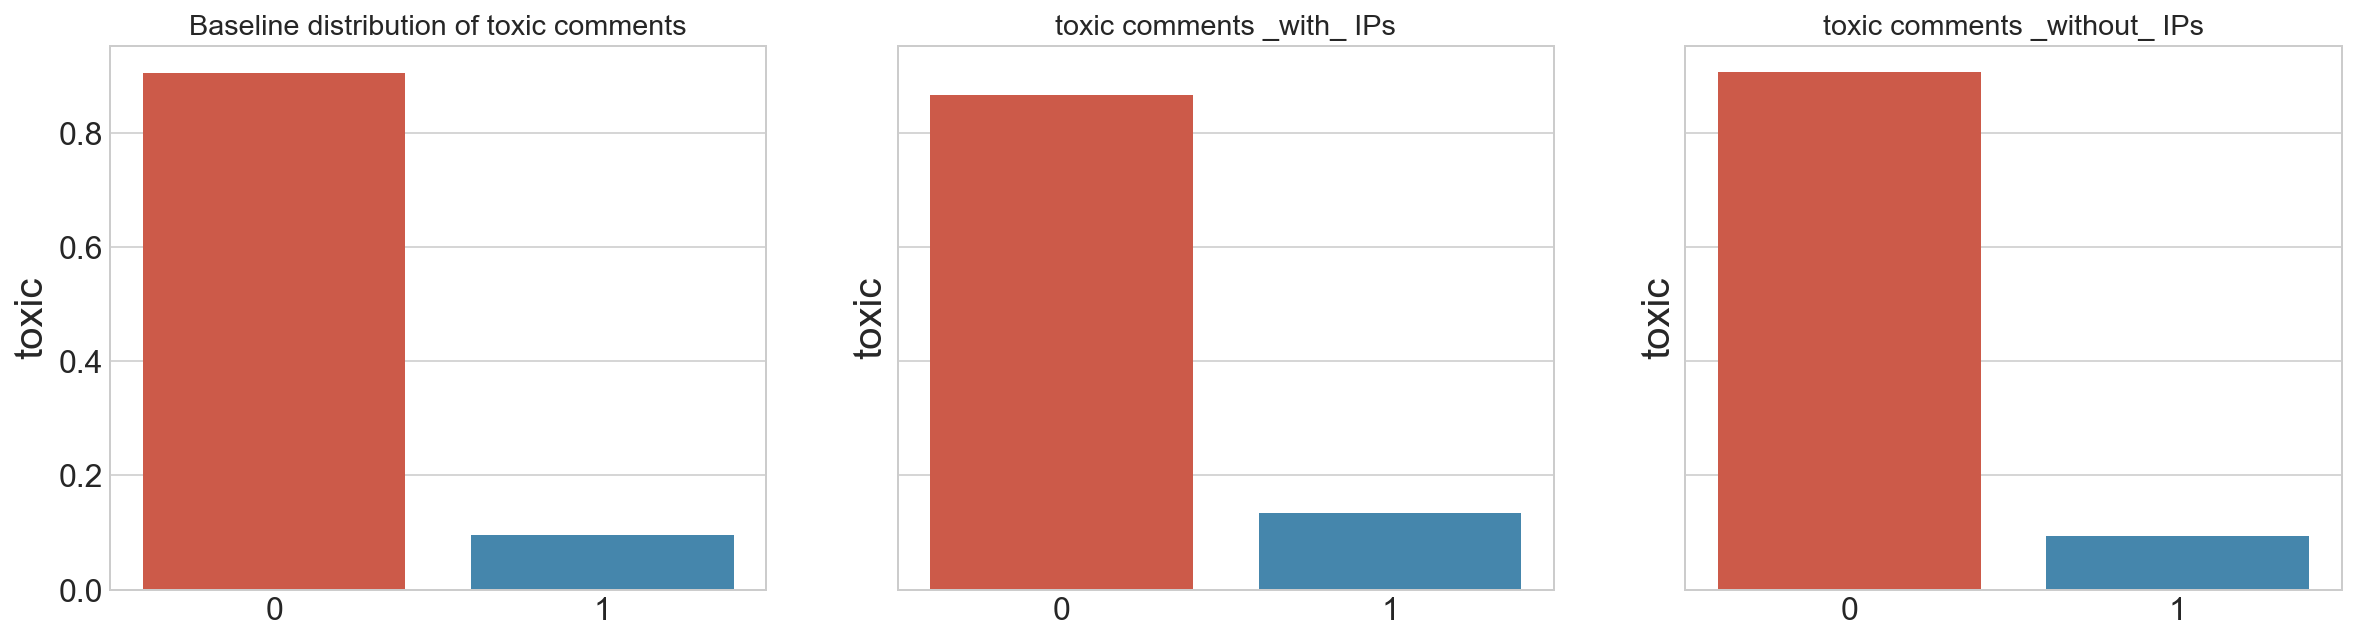

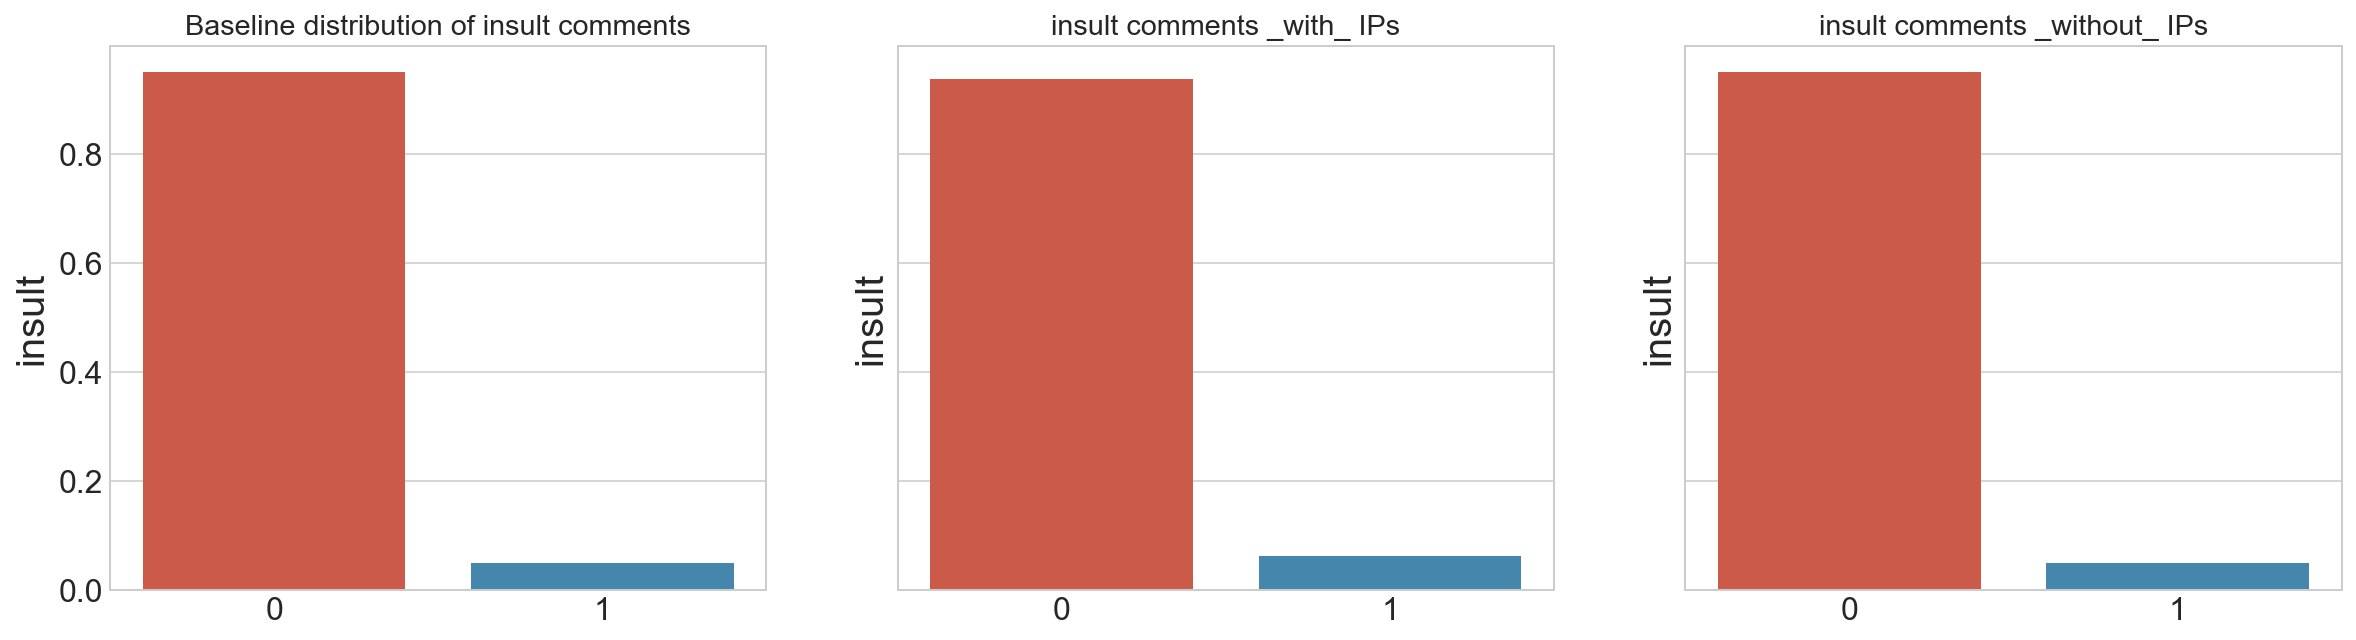

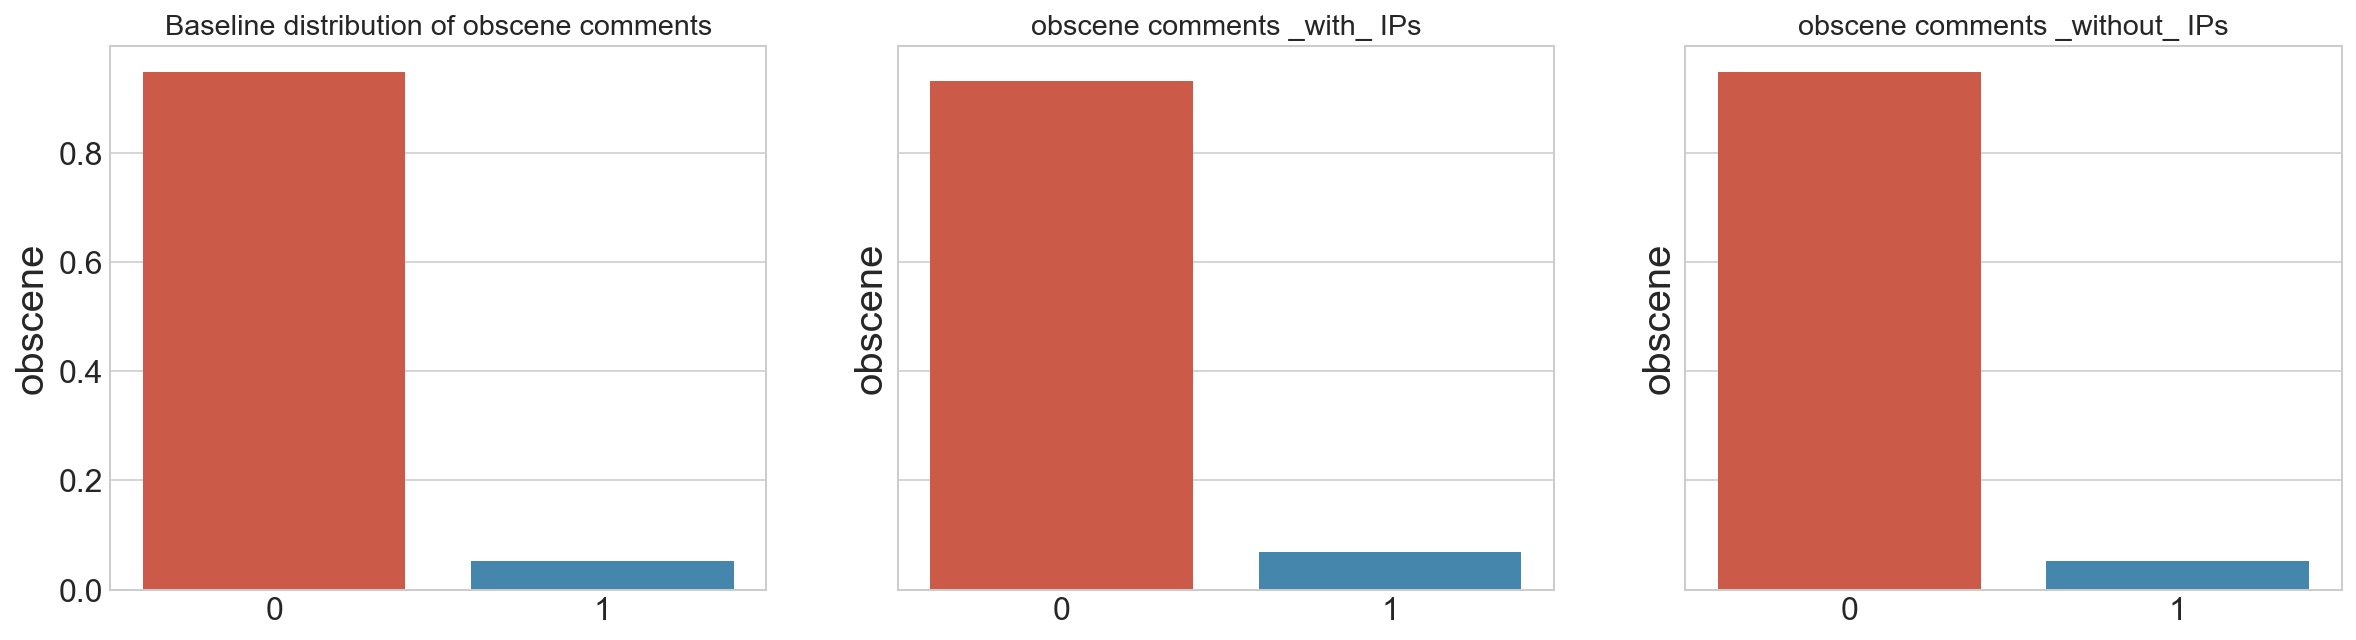

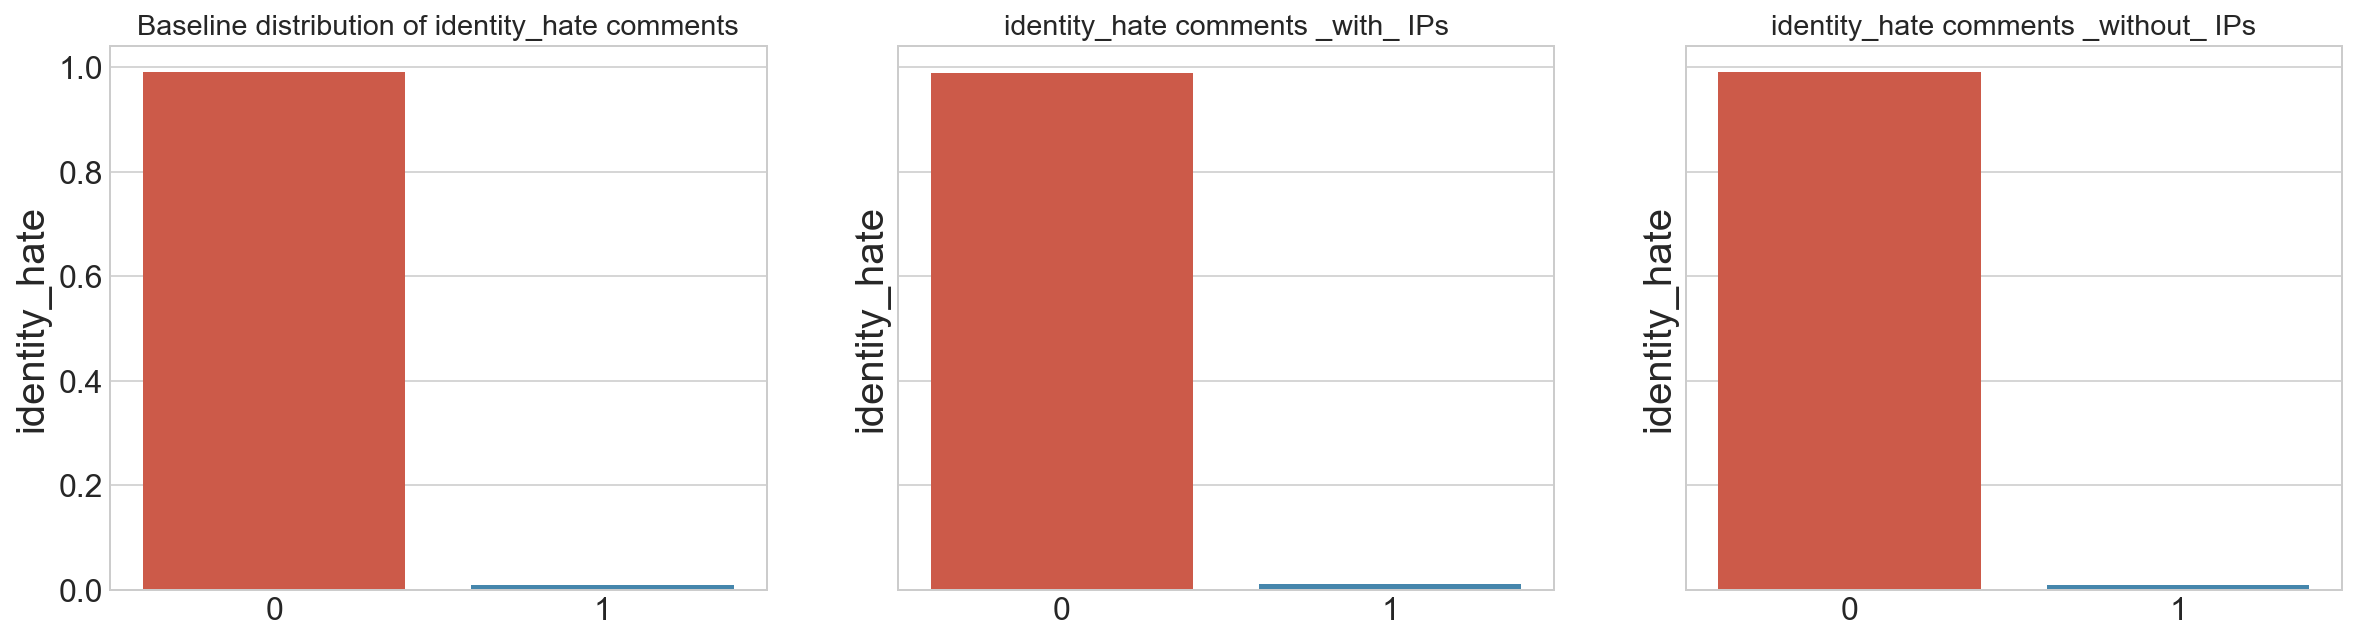

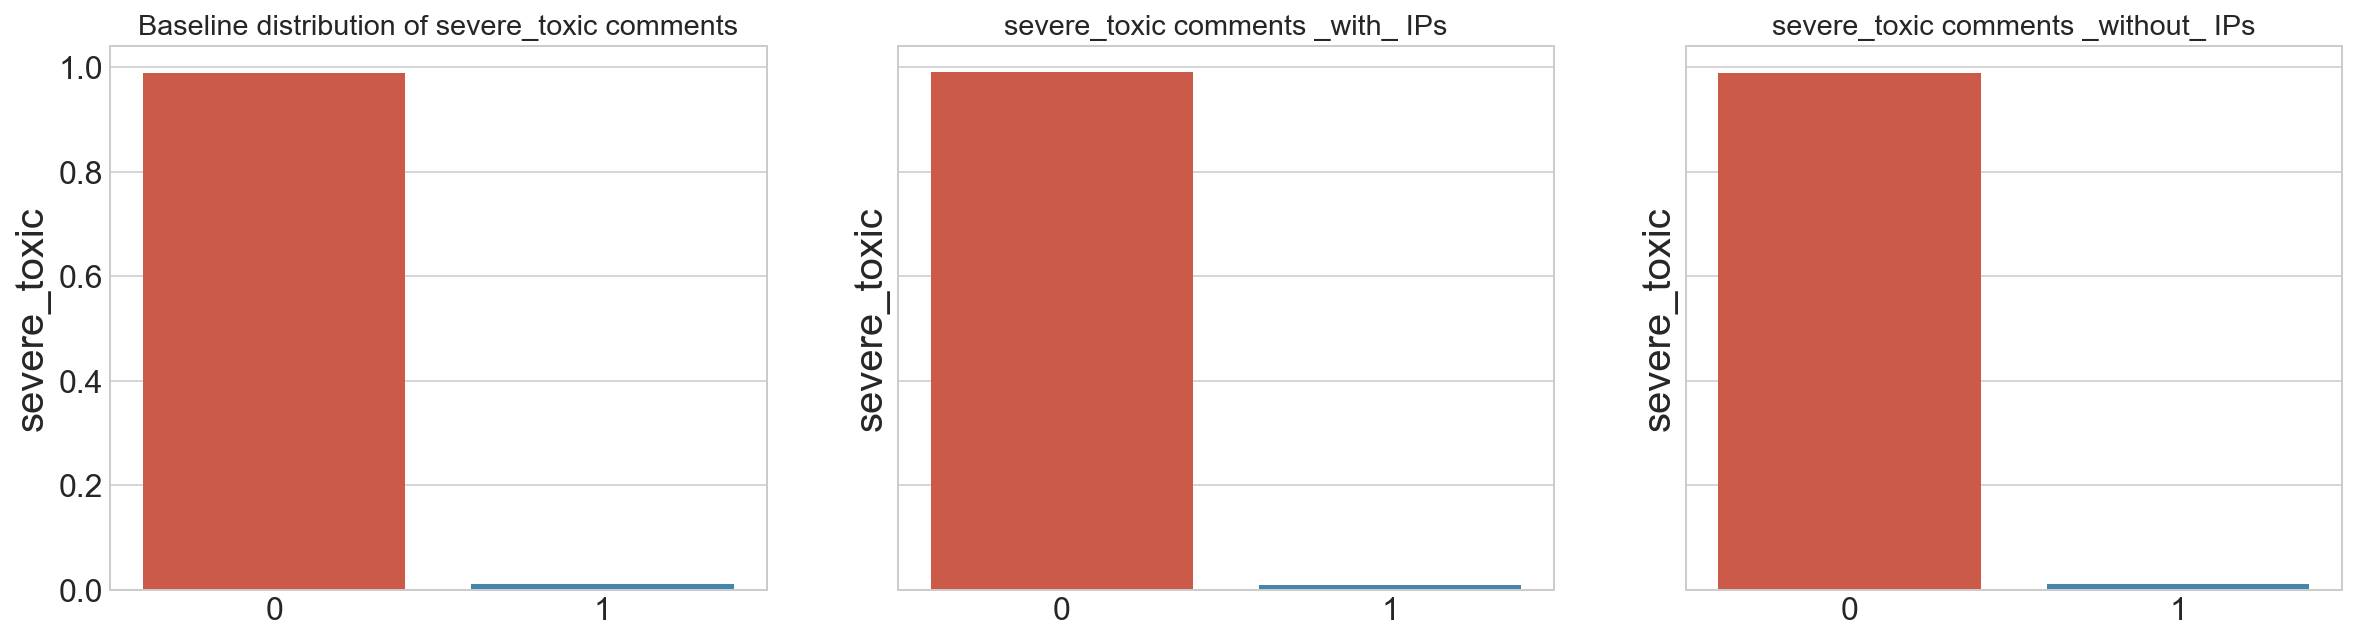

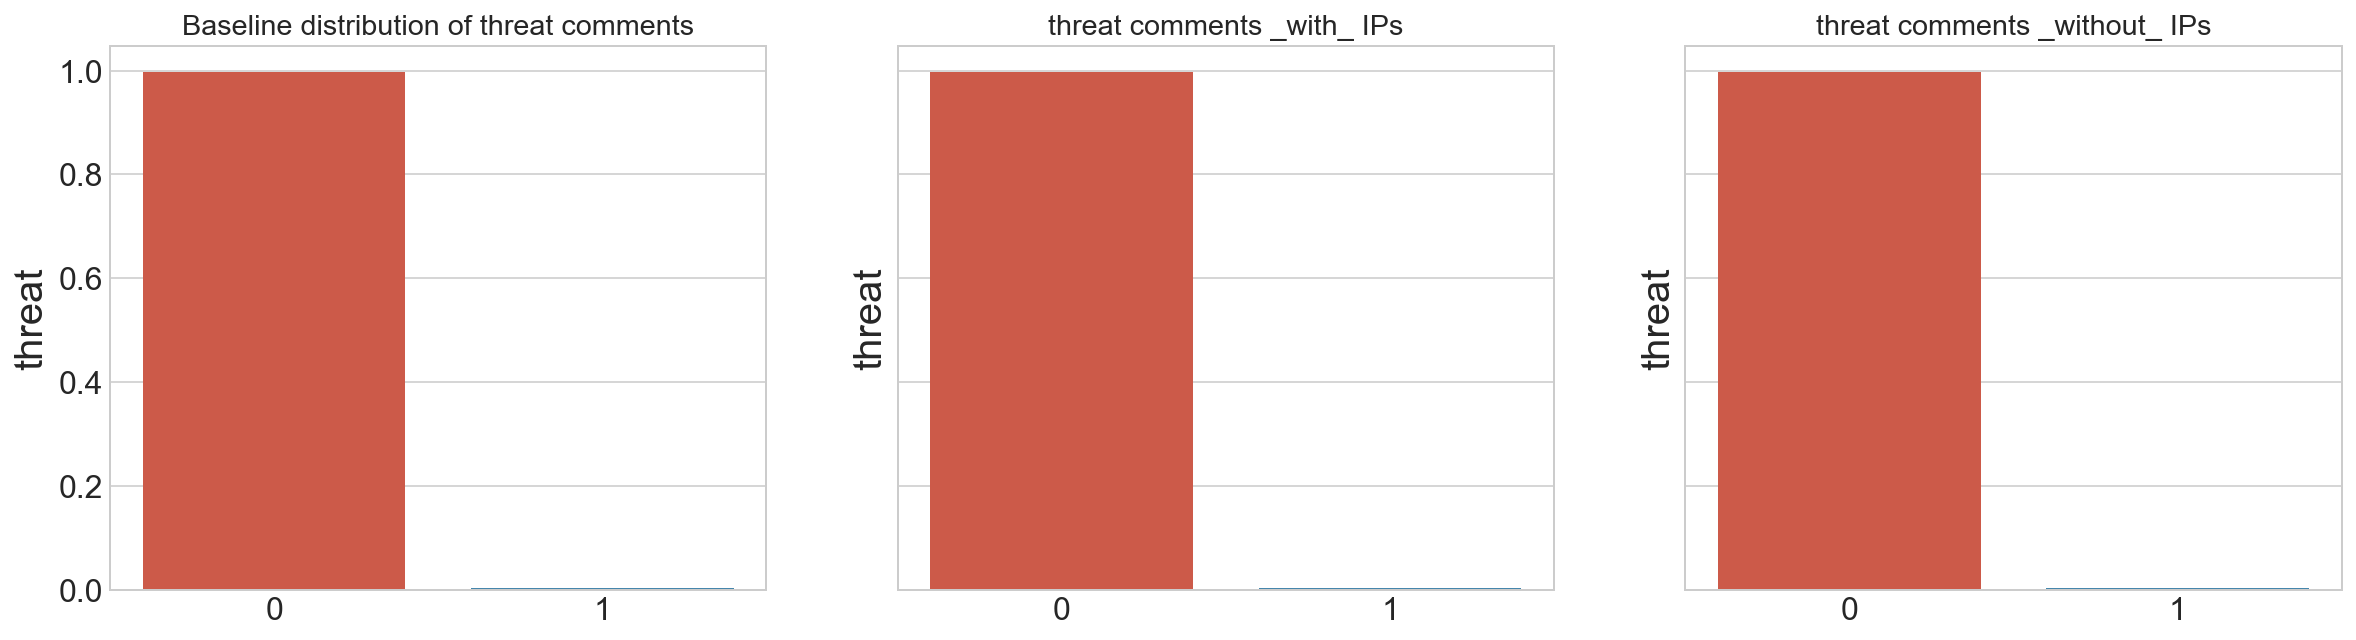

In [395]:
for target in targets:
    f, (ax1, ax2, ax3) = sns.mpl.pyplot.subplots(1, 3, figsize=(20,5), sharey="all")

    ax1.set_title("Baseline distribution of "+target+" comments")
    sns.barplot(x=data[target].value_counts().index, y=data[target].value_counts(normalize=True), ax=ax1)
    ax2.set_title(target+" comments _with_ IPs")
    sns.barplot(x=comments_with_ips[target].value_counts().index, y=comments_with_ips[target].value_counts(normalize=True), ax=ax2)
    ax3.set_title(target+" comments _without_ IPs")
    sns.barplot(x=comments_with_no_ips[target].value_counts().index, y=comments_with_no_ips[target].value_counts(normalize=True), ax=ax3);

##### ***Observation***: It appears that the presence of links, usernames, or IPs in comments doesn't have positive effect with respective target classes.

#### Examine relation between words count, unique words count and sentences count in comments and target classes

In [396]:
comments_with_less_than_10_words = data[data['word_cnt'] <= 10]
comments_with_more_than_10_words = data[data['word_cnt'] > 10]
comments_with_single_sentence = data[data['sentence_cnt'] == 1]
comments_with_more_than_one_sentence = data[data['sentence_cnt'] > 1]
comments_with_less_than_10_unique_words = data[data['unique_word_cnt'] <= 10]
comments_with_more_than_10_unique_words = data[data['unique_word_cnt'] > 10]

for target in targets:
    print("Percent of '{1}' comments with <= 10 words          : {0}%".\
          format(round(1-comments_with_less_than_10_words[target].value_counts(normalize=True)[0],2),target))
    print("Percent of '{1}' comments with > 10 words           : {0}%".\
          format(round(1-comments_with_more_than_10_words[target].value_counts(normalize=True)[0],2),target))

    print("Percent of '{1}' comments with 1 sentence           : {0}%".\
          format(round(1-comments_with_single_sentence[target].value_counts(normalize=True)[0],2),target))
    print("Percent of '{1}' comments with > 1 sentence         : {0}%".\
          format(round(1-comments_with_more_than_one_sentence[target].value_counts(normalize=True)[0],2),target))

    print("Percent of '{1}' comments with <= 10 unique words   : {0}%".\
          format(round(1-comments_with_less_than_10_unique_words[target].value_counts(normalize=True)[0],2),target))
    print("Percent of '{1}' comments with > 10 unique words    : {0}%".\
          format(round(1-comments_with_more_than_10_unique_words[target].value_counts(normalize=True)[0],2),target))
    print()

Percent of 'toxic' comments with <= 10 words          : 0.16%
Percent of 'toxic' comments with > 10 words           : 0.09%
Percent of 'toxic' comments with 1 sentence           : 0.11%
Percent of 'toxic' comments with > 1 sentence         : 0.09%
Percent of 'toxic' comments with <= 10 unique words   : 0.17%
Percent of 'toxic' comments with > 10 unique words    : 0.08%

Percent of 'insult' comments with <= 10 words          : 0.09%
Percent of 'insult' comments with > 10 words           : 0.04%
Percent of 'insult' comments with 1 sentence           : 0.06%
Percent of 'insult' comments with > 1 sentence         : 0.04%
Percent of 'insult' comments with <= 10 unique words   : 0.09%
Percent of 'insult' comments with > 10 unique words    : 0.04%

Percent of 'obscene' comments with <= 10 words          : 0.1%
Percent of 'obscene' comments with > 10 words           : 0.04%
Percent of 'obscene' comments with 1 sentence           : 0.06%
Percent of 'obscene' comments with > 1 sentence         :

## Feature Transformation

#### Helper function to transform and pre-process all comment texts

In [24]:
def cleaner_text(comment):
    text = comment.lower()
    
    # strip html
    text = BeautifulSoup(text, "html.parser").get_text()
    
    # remove things in square []
    text = re.sub('\[[^]]*\]', ' ', text)
    
    # remove linebreaks
    text = re.sub("\\n", " ", text)
    
    # remove "leaky" feature IP
    text = re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}", " ", text)
    
    # replace contractions
    text = contractions.fix(text)
    
    # remove "leaky" feature usernames
    text = re.sub("\[\[.*\]", " ", text)
    
    # remove punctuation
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # remove non-ascii
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    text = nlp(text)
    # lemmatize verbs and remove stop words
    text = [str(i.lemma_) for i in text if str(i.orth_) not in stop] 
    
    text = ' '.join(text)
    
    return text

## Machine Learning and Modeling

In [25]:
from sklearn.externals import joblib
import pickle as pk
from scipy.sparse import hstack
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from bs4 import BeautifulSoup
import contractions #pip install contractions
import string, unicodedata

In [26]:
# Create a list of targets so it's easy to loop through them to create models 
targets = ['toxic', 'severe_toxic', 'obscene', 'insult', 'identity_hate','threat']

#### Setup generic TfidfVectorizer for baseline models

In [27]:
def tfidf_vectorized_features(txt):
    # Create word vectorizer 
    word_vectorizer = TfidfVectorizer(
        sublinear_tf=True,
        strip_accents='unicode',
        stop_words='english'
    )

    # Fit vectorizer
    word_vectorizer.fit(txt)

    # Transform training dataset
    features = word_vectorizer.transform(txt)
    
    return features

### Transform / clean comments

In [ ]:
# Transform / clean comments
data["clean_comment_text"] = data["comment_text"].apply(cleaner_text)

# # save for future ref
# data.to_csv("clean_train_data_all_rows.csv")

### Baseline Models -- DummyClassifier

Use DummyClassifier to create baseline models using stratified train_test_split cross-validation

In [36]:
# Create function so Baseline Model - DummyClassifiers creation is repeatable without having to run this cell
def create_baseline_dummy_models():  
    
    print("Baseline Models - DummyClassifiers in progress\n")
    
    # Create features
    features = tfidf_vectorized_features(data['clean_comment_text'])

    # Loop through six (6) targets and create baseline model for each target using stratified train_test_split cross-validation
    for target in targets:
        y = data[target]

        # Split data in training and test sets
        X_train,X_test,y_train,y_test = train_test_split(features,y,random_state=42,stratify=y)

        # Create dummyclassifier with "stratified" strategy which generates predictions 
        # by respecting the training set's class distribution
        dumb_model = DummyClassifier(strategy='stratified')
        dumb_model.fit(X_train, y_train)
        y_dumb_preds = dumb_model.predict(X_test)
        y_dumb_proba = dumb_model.predict_proba(X_test)

        cv_roc_auc_score = metrics.roc_auc_score(y_test, y_dumb_proba[:,1])
        cv_accuracy_score = metrics.accuracy_score(y_test, y_dumb_preds)

        # Print roc_auc_score and accuracy score
        print("Accuracy score for {1} comments : {0}".format(cv_accuracy_score,target))
        print("ROC AUC score for {1} comments  : {0}".format(cv_roc_auc_score,target))
        cf_matrix = metrics.confusion_matrix(y_test, y_dumb_preds)
        tn, fp, fn, tp = cf_matrix.ravel()
        print("Confusion matrix (TN, FP, FN, TP): ", (tn, fp, fn, tp))
        print("False Negatives : {0}".format(fn))
        print()
              
    print("Baseline Models - DummyClassifiers is complete")

create_baseline_dummy_models()

Baseline Models - DummyClassifiers in progress

Accuracy score for toxic comments : 0.8274133306595142
ROC AUC score for toxic comments  : 0.4996087846098326
Confusion matrix (TN, FP, FN, TP):  (32654, 3415, 3470, 354)
False Negatives : 3470

Accuracy score for severe_toxic comments : 0.9802220941017221
ROC AUC score for severe_toxic comments  : 0.5008724398731674
Confusion matrix (TN, FP, FN, TP):  (39097, 397, 392, 7)
False Negatives : 392

Accuracy score for obscene comments : 0.8971248088637104
ROC AUC score for obscene comments  : 0.5034685606862676
Confusion matrix (TN, FP, FN, TP):  (35682, 2099, 2005, 107)
False Negatives : 2005

Accuracy score for insult comments : 0.9075527034818138
ROC AUC score for insult comments  : 0.501190728467172
Confusion matrix (TN, FP, FN, TP):  (36115, 1809, 1879, 90)
False Negatives : 1879

Accuracy score for identity_hate comments : 0.9829794700824707
ROC AUC score for identity_hate comments  : 0.49841068409931893
Confusion matrix (TN, FP, FN, TP

##### As expected, the accuracy scores are high but ROC AUC is right at .50% and the number of False Negatives are relatively high across the board. These numbers reflect the high imbalance in all the classes.

### Modeling Pipeline

##### Keeping class imbalances in mind, I set up the following pipeline to test various models and their hyperparameters.

In [46]:
#### Setup feature extractors and transformers

# Extracts and returns comment text from the dataframe
def comment_extractor(df):
    return df['clean_comment_text']
comment_extractor_tf = FunctionTransformer(comment_extractor, validate=False) #validate True barks all the time, pro-tip

# Calculates word count for each original/raw comment text and returns it as a feature df
def raw_word_count(df):
    return df['comment_text'].apply(lambda comment: len(str(comment).split())).to_frame()
raw_word_count_tf = FunctionTransformer(raw_word_count, validate=False) #validate True barks all the time, pro-tip

# Calculates unique word count for each original/raw comment text and returns it as a feature df
def raw_unique_word_count(df):
    return df["comment_text"].apply(lambda comment: len(set(str(comment).split()))).to_frame()
raw_unique_word_count_tf = FunctionTransformer(raw_unique_word_count, validate=False) #validate True barks all the time, pro-tip

# Calculates word count for each cleaned comment text and returns it as a feature df
def word_count(df):
    return df['clean_comment_text'].apply(lambda comment: len(str(comment).split())).to_frame()
word_count_tf = FunctionTransformer(word_count, validate=False) #validate True barks all the time, pro-tip

# Calculates unique word count for each cleaned comment text and returns it as a feature df
def unique_word_count(df):
    return df["clean_comment_text"].apply(lambda comment: len(set(str(comment).split()))).to_frame()
unique_word_count_tf = FunctionTransformer(unique_word_count, validate=False) #validate True barks all the time, pro-tip

to_dense_tf = FunctionTransformer(lambda dtm_from_vect: dtm_from_vect.toarray(), validate=False)

# Create function that accpes the target to fit the selected models as argument in addition to optional flags to persist models and 
# predictions for post-modeling EDA
def execute_model_pipeline(target,save_model=False,save_preds=False):
    
    # Setup word vectorizer with params we'd like to stay constant
    word_tfidf_vect = TfidfVectorizer(
        sublinear_tf=True,
        strip_accents='unicode',
        stop_words='english'
    )

    # Setup dictionary of models we'd like to test
    models = {
        'nb': MultinomialNB(),
    #     'xgb': xgb.XGBClassifier()
    #     'rf': RandomForestClassifier()
    }
    
    # Setup model specific params grid
    model_params = {
        'nb': {
            'nb__alpha': [0.05],
#             'nb__class_prior':[[.5, .5],[.1, .9],[.3, .7],[.4, .6]]
#             'nb__class_prior':[[0.1, 0.9]]
#             'nb__class_prior':[[.1, .9]]
            'nb__class_prior':[[.4, .6]]
        },
        'xgb': {
            'xgb__max_depth': [3,4,5],
            'xgb__n_estimators': [100,300,600],
            'xgb__learning_rate': [.05]
        },
        'rf': {
            'rf__max_depth': [3,4,5],
            'rf__n_estimators': [100,300,600]
        }
    }

    y = data[target]
    X_train,X_holdout,y_train,y_holdout = train_test_split(data,y,random_state=42,stratify=y)
    
    raw_text_holdout   = X_holdout['comment_text']
    clean_text_holdout = X_holdout['clean_comment_text']

    print('Mode pipeline for ' + target.upper() + ' in progress!\n')
    
    #Iterate over selected models
    for model_key,model_val in models.items():

        print('\n********** ' + model_key + ' for ' + target.upper() + ' in progress!\n')

        #Setup pipeline 
        pipeline = Pipeline([
            ('features', FeatureUnion([
                ('tfidf_vectorize_pipe', Pipeline([
                    ('extract_comments', comment_extractor_tf),
                    ('word_tfidf_vect', word_tfidf_vect),
                    ('to_dense_tf', to_dense_tf)
                ])),
#                 ('raw_word_count', raw_word_count_tf),
#                 ('raw_unique_word_count', raw_unique_word_count_tf),
#                 ('word_count', word_count_tf),
#                 ('unique_word_count', unique_word_count_tf)
            ])),
            (model_key, model_val)
        ])

        #Setup model params
        params = {
            #Generic/non-model specific params go here
    #         'features__tfidf_vectorize_pipe__word_tfidf_vect__ngram_range': [(1,1),(2,2),(3,3)],
    #         'features__tfidf_vectorize_pipe__word_tfidf_vect__max_features': [5000,10000],
            'features__tfidf_vectorize_pipe__word_tfidf_vect__ngram_range': [(1,1)],
            'features__tfidf_vectorize_pipe__word_tfidf_vect__max_features': [5000],
        }    
        #Add model specific params to the grid
        params.update(model_params[model_key])

        #Setup GridSearchCV and fit pipeline on train split
        gs = GridSearchCV(pipeline, cv=10, param_grid=params, scoring={'AUC': 'roc_auc', 'Accuracy': 'accuracy'}, refit="AUC", verbose=1)
        gs.fit(X_train, y_train)

        print("\nBest GridSearchCV params   :",gs.best_params_)
        print("Best GridSearchCV score    :",gs.best_score_)

        #Score GridSearchCV against holdout split
        gs_score = gs.score(X_holdout, y_holdout) # make sure we're not overfitting
        print("Holdout GridSearchCV Score :", gs_score)
        y_pred_holdout = gs.predict(X_holdout)
        y_proba_holdout = gs.predict_proba(X_holdout)

        print('\nNull accuracy   :', y_holdout.value_counts(normalize=True)[0])
        # Accuracy -- how often is the classifier correct
        print("Accuracy        : {0}".format(metrics.accuracy_score(y_holdout, y_pred_holdout)))   # (TP + TN) / (TP + TN + FP + FN)
        # AUC -- % of the ROC plot that is underneath the curve
        # AUC is useful as a single number summary of classifier performance
        print("ROC AUC Score   : {0}".format(metrics.roc_auc_score(y_holdout, y_proba_holdout[:,1])))    

        cf_matrix = metrics.confusion_matrix(y_holdout, y_pred_holdout)
        tn, fp, fn, tp = cf_matrix.ravel()
        print("\nConfusion matrix (TN, FP, FN, TP): ", (tn, fp, fn, tp))

        # Specificity -- when actual value is negative, how often is the prediction correct
        print("Specificity     : {0}".format(tn / (tn + fp)))                                      # TN / (TN + FP) == all negative
        # Precision -- when a positive value is predicted, how often is the prediction correct
        print("Precision       : {0}".format(metrics.precision_score(y_holdout, y_pred_holdout)))  # TP / (TP + FP)

        # Sensitivity -- when actual value is positive, how often is the prediction correct
        print("\nSensitivity     : {0}".format(metrics.recall_score(y_holdout, y_pred_holdout)))   # TP / (FN + TP) == all positive
        # False Negatives 
        print("False Negatives : {0}".format(fn))
        
        # ROC curve -- see how sensitivity and specificity are affected by various thresholds, without actually changing the threshold
        fpr, tpr, thresholds = metrics.roc_curve(y_holdout, y_proba_holdout[:, 1])

        plt.figure(figsize=(18,8))
        plt.plot(fpr, tpr)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.title('ROC curve for toxic classifier')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.grid(True);

        if (save_preds):
            preds_df = pd.DataFrame()
            preds_df['raw_comment']   = raw_text_holdout
            preds_df['clean_comment'] = clean_text_holdout
            preds_df['predicted']     = y_pred_holdout
            preds_df['actual']        = y_holdout
            preds_df['prob_0']        = y_proba_holdout[:,0] # Store the predicted probabilities for class 0
            preds_df['prob_1']        = y_proba_holdout[:,1] # Store the predicted probabilities for class 1
            preds_df.to_csv(model_key + '_' + target + '_4_6_' + str(fn) + '.csv')
            
        if (save_model):
            best_model = gs.best_estimator_.steps[1][1] 
            joblib.dump(best_model, model_key + '_' + target + '_4_6_' + str(fn) + '.pkl')

        print('\n********** ' + model_key + ' for ' + target.upper() + ' in complete!\n')

    print('\nModel pipeline for ' + target.upper() + ' is complete!\n\n')

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.11 µs
Mode pipeline for TOXIC in progress!


********** nb for TOXIC in progress!

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  6.5min finished



Best GridSearchCV params   : {'features__tfidf_vectorize_pipe__word_tfidf_vect__max_features': 5000, 'features__tfidf_vectorize_pipe__word_tfidf_vect__ngram_range': (1, 1), 'nb__alpha': 0.05, 'nb__class_prior': [0.4, 0.6]}
Best GridSearchCV score    : 0.9501311812070261
Holdout GridSearchCV Score : 0.9504912952464076

Null accuracy   : 0.9041435840874339
Accuracy        : 0.8325771438598251
ROC AUC Score   : 0.9504912952464076

Confusion matrix (TN, FP, FN, TP):  (29715, 6354, 325, 3499)
Specificity     : 0.8238376445146802
Precision       : 0.3551202679386989

Sensitivity     : 0.915010460251046
False Negatives : 325

********** nb for TOXIC in complete!


Model pipeline for TOXIC is complete!




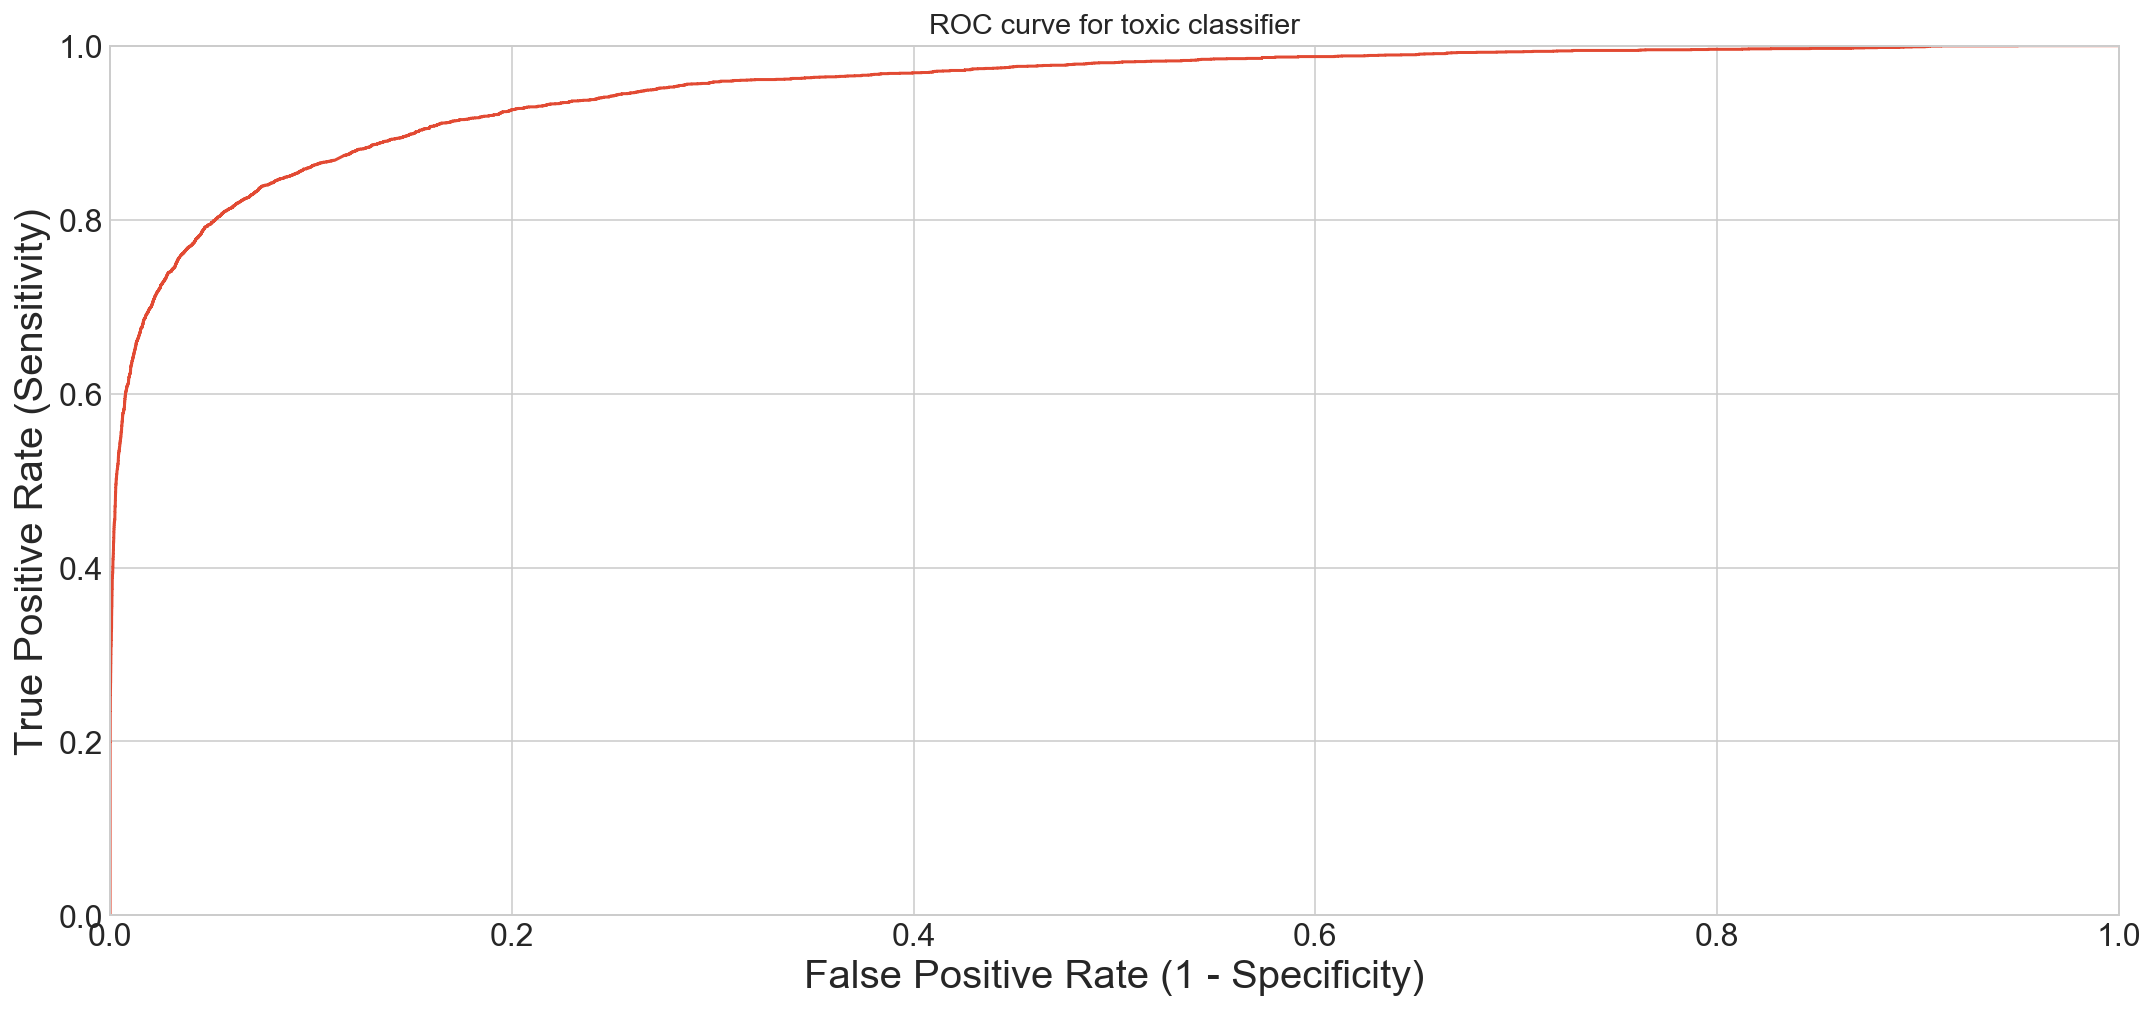

In [47]:
%time
# Fit selected models and generate predictions on holdout for 'toxic' class
execute_model_pipeline('toxic')

# Iterate over targets dict and fit the selected models and generate predictions on holdout on all six (6) classes
# for target in targets:
#     execute_model_pipeline(target)

### Results

##### Change in class_prior impacts Sensitivity, False Negatives and Accuracy. Since in this case the goal was to find a (reasonable) balance between the three, I was able to achieve that by setting class_prior of the MultinomialNB model to [0.4, 0.6] which resulted in **Sensitivity of 0.91, False Negatives to 327 and Accuracy of 0.82**